<a href="https://colab.research.google.com/github/Ivelina0/Imperial_Stuff/blob/main/ASM_CW_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm, invgamma, expon, uniform , multivariate_normal, gamma
import pickle as pickle
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf as autocorr
import os 

# from scipy.stats import norm, invgamma, expon, uniform , multivariate_normal

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set up - Stochastic Volatility Question 2

In [ ]:
# model params
rho = 0.91
sigma = 1
beta = 0.5
V_var = sigma**2            # Process/hidden state noise variance. 

T=100 # Number of time steps.

# Initial state/ Set up
np.random.seed(42)
x0 = 0.0 
true_x = np.zeros((T,1))   # Hidden states.
y = np.zeros((T,1))        # Observations.
true_x[0,:] = x0      # Initial state.   
V = np.random.normal(size = (T,1))  # hidden state noise
W = np.random.normal(size = (T,1))  # observations noise

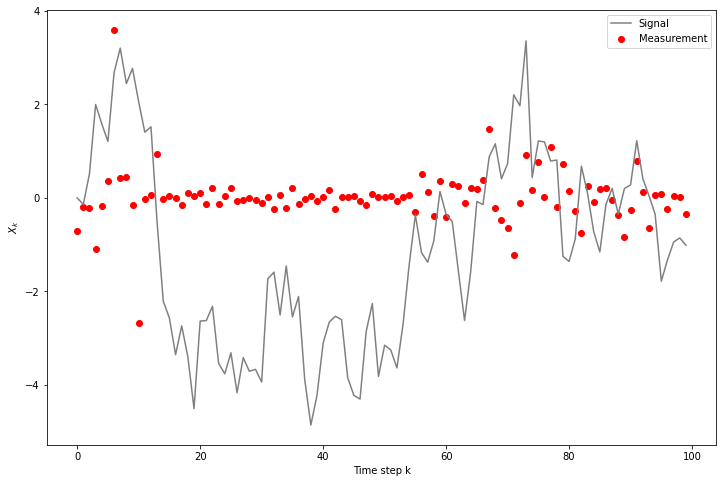

In [ ]:
# GENERATE TRUE STATE AND MEASUREMENTS:

def gen_data_qs2(T):

  y[0] = beta*np.exp(true_x[0]/2)*W[0] 

  for t in range(1,T):
    true_x[t] = rho*true_x[t-1] + sigma*V[t] 
    y[t] = beta*np.exp(true_x[t] /2 )*W[t]  

  return y, true_x

y, true_x = gen_data_qs2(T)

fig, axs = plt.subplots(1, 1, figsize=(12,8) )

axs.plot(range(T), true_x, label = "Signal", color="grey")
axs.set_ylabel('$X_k$')
axs.set_xlabel('Time step k')
axs.scatter(range(T), y, label = "Measurement", color="red")
plt.legend();

# SIR function

In [ ]:
def optimal_SIR(sd, N = 500, T=100, beta=0.5, sigma=1, rho = 0.91):

  np.random.seed(seed=sd)

  # filtering approx
  x_SIR2 = np.zeros((N,T))
  # prediction approx
  xu_SIR2 = np.zeros((N,T))
  # normalised weights
  q_SIR2 = np.zeros((N,T))
  # unormalised weights
  qq_SIR2 = np.zeros((N,T))
  # log of weights for ease of computation
  log_w=np.zeros((N,T))
  # ancestors index
  I = np.zeros((N,T))
  log_rec=np.zeros((T,1))

  # INIT: SAMPLE FROM THE PRIOR: N(0 , sigma^2/(1-pho)) = N(0, 1/(1-0.91))
  xu_SIR2[:,0:1] = np.random.normal(0,1/(1-(rho**2)), size=(N,1))
  v_0 = ( beta*np.exp(xu_SIR2[:,0:1]/2) )**2

  # the initial unnormalised weights - mean 0 amnd s.d. b*exp(X_0/2)
  qq_SIR2[:,0:1] = np.exp(-0.5* (1/v_0)*(y[0])**(2))/(np.sqrt(2*np.pi*v_0))
  # normalised weights
  q_SIR2[:,0:1] = qq_SIR2[:,0:1]/np.sum(qq_SIR2[:,0:1])

  # resampling STEP
  I[:,0:1] = np.random.choice( list(range(N)) , N, replace=True, p = q_SIR2[:,0] ).reshape((N,1))

  # resampled Xhat values
  x_SIR2[:,0:1] = xu_SIR2[ I[:,0:1].astype('int32').tolist() ,0]
  log_rec[:,0:1]=np.log(np.mean( qq_SIR2[:,0:1] ))

  # UPDATE AND PREDICTION STAGES:
  for t in range(T-1):

    # update mean and var at each step
    var_n = ( 1 + (1/(2*beta**2) ) * (y[t+1]**2) * np.exp(- rho * x_SIR2[:,t:t+1] )  )**(-1) 
    #print(var_n.shape)

    mu_n = (rho * x_SIR2[:,t:t+1]) - ( 1 - (1/(beta**2) ) * (y[t+1]**2) * np.exp(-rho * x_SIR2[:,t:t+1] ) )*var_n /2
    #print(mu_n.shape)

    # sample new X
    xu_SIR2[:,t+1:t+2] = mu_n + np.sqrt(var_n) * np.random.normal(0,1,size=(N,1))

    # compute each piece of the weights
    log_prior = -0.5 * (  (xu_SIR2[:,t+1:t+2] - rho * x_SIR2[:,t:t+1]  )**2 ) 
    #print(log_prior.shape)

    # log_likelihood =  -0.5 * ( (1/(beta**2))*np.exp( - x_SIR2[:,t:t+1] ) * ( y[t+1]**2 ) + xu_SIR2[:,t+1:t+2] ) 
    log_likelihood =  -0.5 * ( (1/(beta**2))*np.exp( - xu_SIR2[:,t+1:t+2] ) * ( y[t+1]**2 ) + xu_SIR2[:,t+1:t+2] )
    #print(log_likelihood.shape)

    log_proposal =  -0.5 * ( (1/var_n) * ( xu_SIR2[:,t+1:t+2] - mu_n  )** 2  )
    #print(log_proposal.shape)

    log_proposal_terms =  (( y[t+1]**2 )*np.exp( - rho*x_SIR2[:,t:t+1]) )/beta**2 + rho *x_SIR2[:,t:t+1] - (1/4) * ( (( 1 - (( y[t+1]**2 )*np.exp( - rho*x_SIR2[:,t:t+1]) )/beta**2 ))**2 ) * var_n
    #print(log_proposal_terms.shape)

    log_normalising_constants = np.log(np.sqrt(2*np.pi*(sigma**2))) + np.log(np.sqrt(2*np.pi*((beta**2)*np.exp(- x_SIR2[:,t:t+1])))) - np.log(np.sqrt(2*np.pi*(var_n))) 
    #print(log_normalising_constants.shape)

    all_terms = log_prior + log_likelihood - log_proposal - log_proposal_terms - log_normalising_constants
    #all_terms = log_prior + log_likelihood - log_proposal  - log_normalising_constants
    log_w[:,t+1:t+2] = all_terms

    # implementing log exp sum trick for weights
    offset=np.max(log_w[:,t+1])
    log_w[:,t+1] = log_w[:,t+1] - offset
    qq_SIR2[:,t+1] = np.exp(log_w[:,t+1])

    # normalised weight
    q_SIR2[:,t+1] = qq_SIR2[:,t+1]/sum(qq_SIR2[:,t+1])

    # p(y_n)
    log_rec[:,t+1:t+2] = np.log(np.mean( qq_SIR2[:,t+1] ) ) + offset

    # sampler offsprings
    I[:,t+1] = np.random.choice( list(range(N)) , N, replace=True, p = q_SIR2[:,t+1] ) #index
    x_SIR2[:,t+1] = xu_SIR2[ I[:,t+1].astype('int32').tolist() ,t+1]
    x_SIR2[:, :t] = x_SIR2[ I[:,t+1].astype('int32').tolist(), :t ]

  return x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec

In [ ]:
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = 500, T=100, beta=0.5, sigma=1, rho = 0.91)

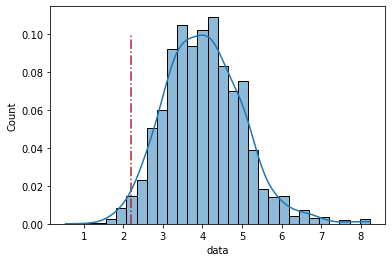

In [ ]:
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = 500, T=100, beta=0.5, sigma=1, rho = 0.91)
n=10
b=int(180/5)
df = pd.DataFrame({"data": xu_SIR2[:,n-1], "weight_PF": q_SIR2[:,n-1] })

sns.histplot(df, x="data",  weights="weight_PF",bins=30, kde=True)
plt.vlines( true_x[n-1],ymin = 0, ymax=0.1,  color="brown", linestyles='-.', label = 'True $X_n$'  )
plt.show()

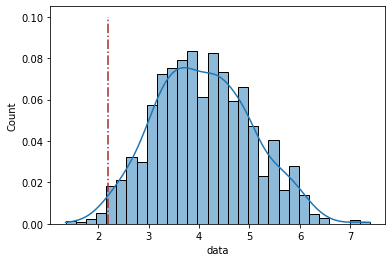

In [ ]:
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=4022, N = 500, T=100, beta=0.5, sigma=1, rho = 0.91)
n=10
b=int(180/5)
df = pd.DataFrame({"data": xu_SIR2[:,n-1], "weight_PF": q_SIR2[:,n-1] })

sns.histplot(df, x="data",  weights="weight_PF",bins=30, kde=True)
plt.vlines( true_x[n-1],ymin = 0, ymax=0.1,  color="brown", linestyles='-.', label = 'True $X_n$'  )
plt.show()

# FFBSm 

There is a more efficient computational method when calculating the terms $W_n f(X_{n+1}| X_n)$ and normalising it. Then multiplying by $W_{n|n+1}$, but i stuck to the formula exactly.

In [ ]:
def FFBSm_optimal(xu_SIR, q_SIR, beta=0.5, sigma=1, rho = 0.91):

  N = q_SIR.shape[0]
  T = q_SIR.shape[1]

  # new unnormalised & normalised weights storage
  qq_FFBSm = np.zeros((N,T))
  trans_matrix = np.zeros((N,N)) # f(X_n+1 | X_n)

  # initialise backwards pass
  qq_FFBSm[:,T-1:T] = q_SIR[:,T-1:T]

  #### Trial 2 the for loop over reversed time
  for t in reversed(range(1,T)):
    # print(t)

    for j in range(N):
      
      trans_matrix[:,j:j+1] = np.exp(-0.5 * (  (xu_SIR[j , t:t+1] * np.ones((N,1)) - rho * xu_SIR[:,t-1:t]  )**2 ) - np.log(np.sqrt(2*np.pi*(sigma**2))) ) 

    # sum over all states i (l in pseudo code), the product of trans_matrix*Weights (normalised i at time n) from PF
    bottom_vector = np.sum((q_SIR[:,t-1:t] * np.ones((1,N)) ) * trans_matrix , axis=0)
    top_matrix =  (qq_FFBSm[:,t:t+1].T * np.ones((N,1)) ) * trans_matrix

    # sum over all js, i.e. sum over each row i 
    term2 = np.sum((top_matrix / bottom_vector) , axis=1).reshape((N,1))

    # the new weight given all info 
    qq_FFBSm[:, t-1:t] =  q_SIR[:,t-1:t]  * term2
  return qq_FFBSm

In [ ]:
qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = 0.91)
np.round(qq_FFBSm[:3,:5], 4)

array([[0.    , 0.    , 0.0003, 0.    , 0.0029],
       [0.0013, 0.    , 0.0103, 0.    , 0.0009],
       [0.0076, 0.    , 0.0011, 0.    , 0.0023]])

In [ ]:
np.sum(qq_FFBSm, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Plots Qs 2.2 N=500

In [ ]:
def plot_dist(n,N):
  b=int(180/5) # random choice
  df = pd.DataFrame({"data": xu_SIR2[:,n-1], "weight_FFBSm": qq_FFBSm[:,n-1],"weight_PF": q_SIR2[:,n-1] })

  fig, ax = plt.subplots(1, 1, figsize=(14,8))

  sns.histplot(ax=ax, data= df, x="data",  weights="weight_FFBSm",bins=b, color= "blue", label="FFBSm", kde=True)
  sns.histplot(ax=ax, data = df, x="data",  weights="weight_PF",bins=b,color= "green", label="PF", kde=True)
  plt.vlines( true_x[n-1],ymin = 0, ymax=0.2,  color="brown", linestyles='-.', label = 'True $X_n$'  )

  # Plot settings
  axs.set_xlabel('Time step n')
  plt.title("True $X_n$ vs $\hat{p}[X_n|Y_{0:n}]$ vs. $\hat{p}[X_n|Y_{0:T}]$,"+" for N={samples}, n= {time}".format(samples = N, time=n))
  plt.legend();

-238.47914098227739


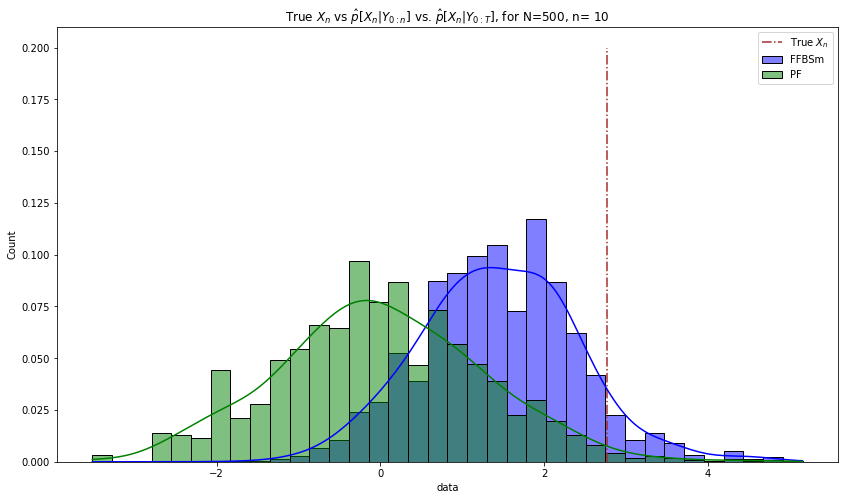

In [ ]:
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = 500, T=100, beta=0.5, sigma=1, rho = 0.91)
qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = 0.91)
print(np.sum(log_rec))
plot_dist(n=10,N=500)
plt.savefig('n_10_N_500,.png', dpi=300) 

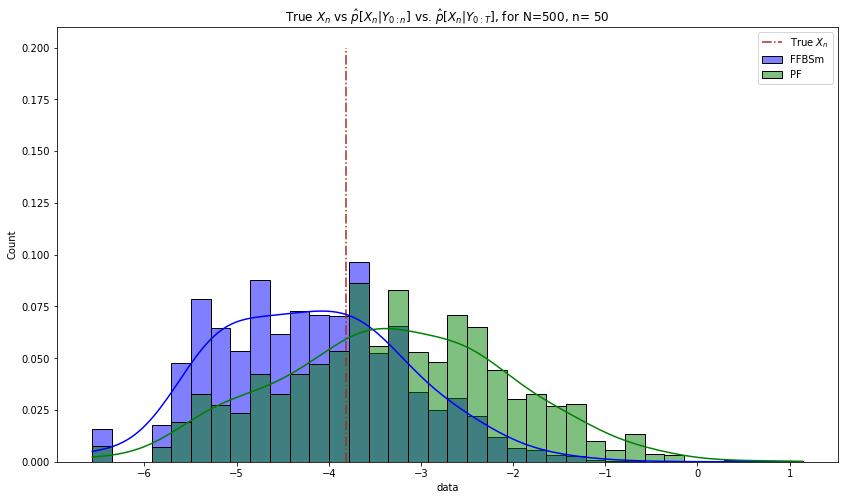

In [ ]:
plot_dist(n=50,N=500)
plt.savefig('n_50_N_500,.png', dpi=300) 

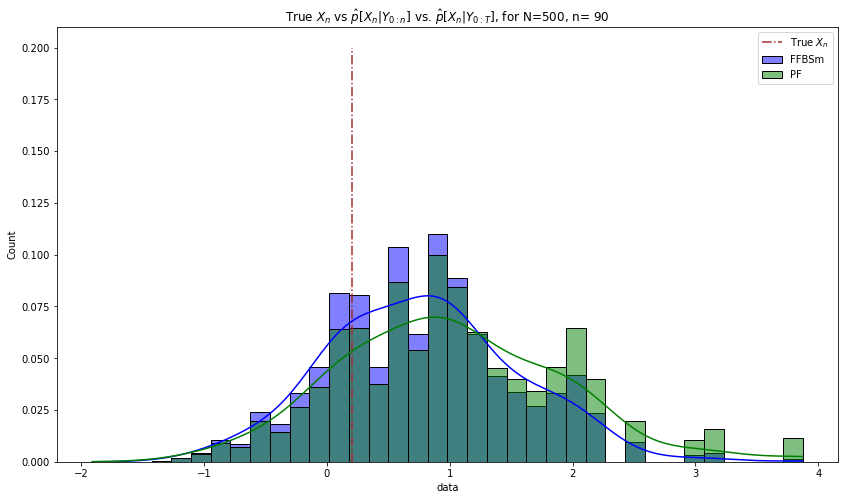

In [ ]:
plot_dist(n=90,N=500)
plt.savefig('n_90_N_500,.png', dpi=300) 

In [ ]:
# sns.histplot(df, x="data",  weights="weight_PF",bins=30, kde=True)
# plt.vlines( true_x[n-1],ymin = 0, ymax=0.1,  color="brown", linestyles='-.', label = 'True $X_n$'  )
# plt.show()

# Plots Qs 2.2 N=50

In [ ]:
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = 50, T=100, beta=0.5, sigma=1, rho = 0.91)
qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = 0.91)

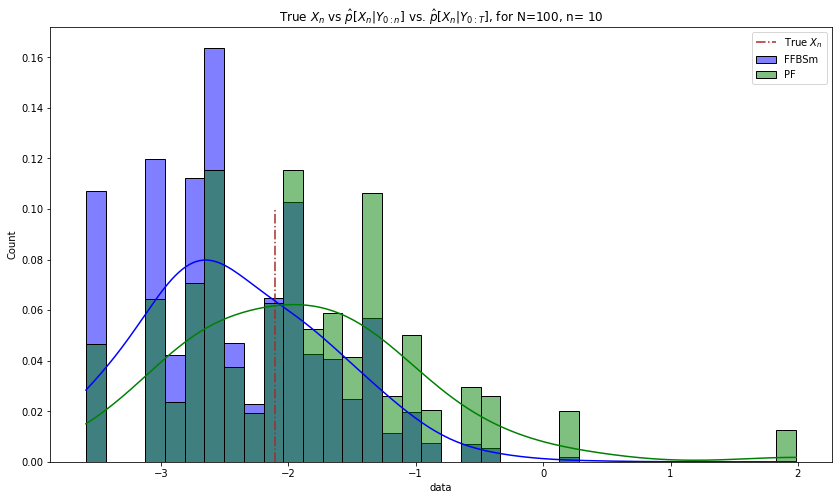

In [ ]:
plot_dist(n=10,N=100)

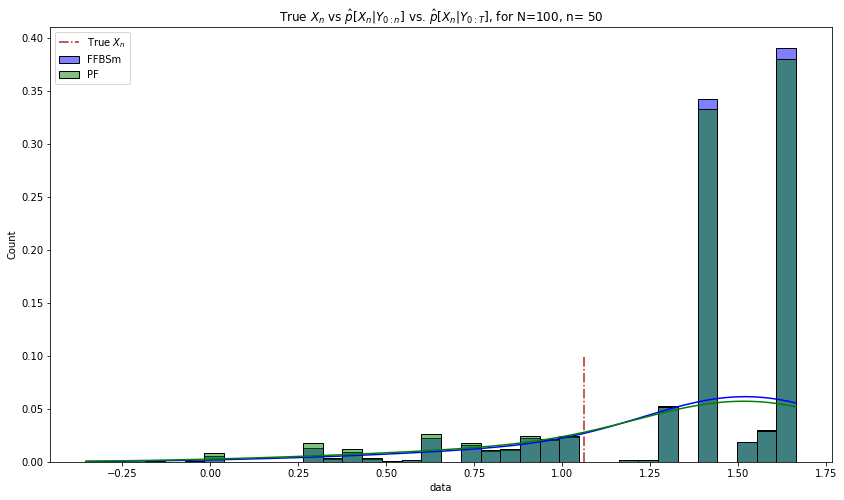

In [ ]:
plot_dist(n=50,N=100)

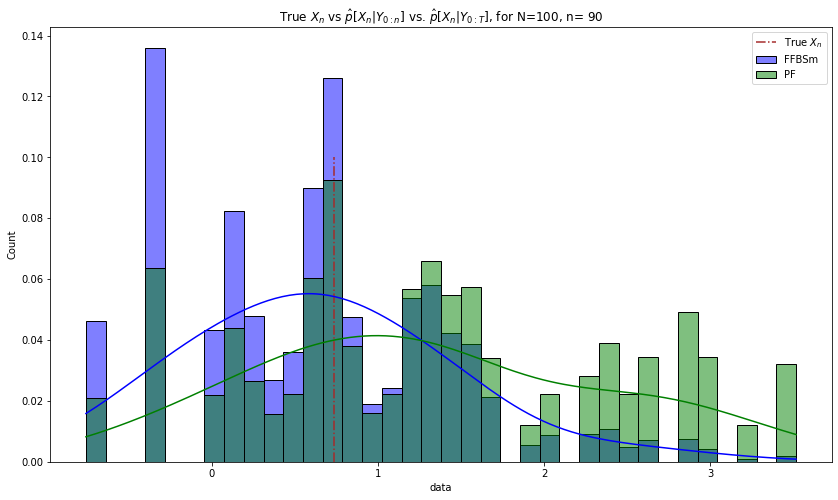

In [ ]:
plot_dist(n=90,N=100)

Clearly, the more particles there are the better the approximations.

The forward filter, backwards smoother does slightly better at approximating the distributions at each time step but the process is off-line, and has $O(TN^2)$ operations in total.

When computing particle estimates,, i.e. smooth additive functions, the PF has a smaller bias bound $\leq \frac{T}{N^2}$ for $N^2$ particles, whereas the FFBSm has a bound $\leq \frac{T}{N}$ for the same computational cost, with $N$ particles. 

However, the PF has a larger variance bound $\leq \frac{T^2}{N^2}$, compared to the $\leq \frac{T}{N}$ for the FFBSm, so the more expensive FFBSm method dominates in terms of variance. 

Running both with much larger number of particles, would give better results.

Note, numpy vectorisation is used to parallerise the code.

# Qs 2.3 plots

$E[X_n|Y_{0:T}]$

$E[X_n|Y_{0:n}]$

In [ ]:
## with N = 100
NN = 100

# PF
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = NN, T=100, beta=0.5, sigma=1, rho = 0.91)
# FFBSm
qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = 0.91)

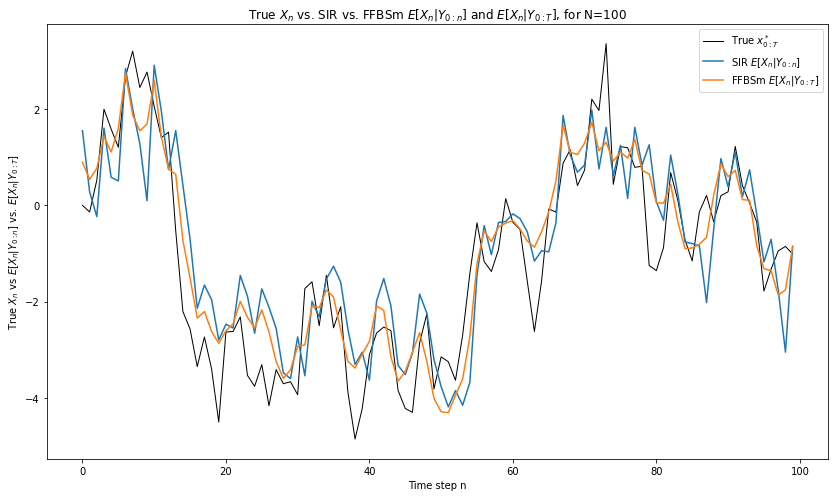

In [ ]:
# the expectations x 3 lines, plus the true X_n

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

axs.plot(range(T), true_x, label = "True $x^*_{0:T}$",linewidth=1, color="black")
axs.plot(range(T), np.sum(q_SIR2 * xu_SIR2, axis=0 ), label = "SIR $E[X_n|Y_{0:n}]$")#, linestyle='-.' ,  color="orange")
#axs.plot(range(T), np.mean(x_SIR2, axis=0 ), label = "SIR $E[X_n|Y_{0:T}]$")#, linestyle='-.' ,  color="red")
axs.plot(range(T), np.sum(qq_FFBSm * xu_SIR2, axis=0 ), label = "FFBSm $E[X_n|Y_{0:T}]$")#, linestyle='-.' ,  color="darkblue")

# Plot settings
axs.set_ylabel('True $X_n$ vs $E[X_n|Y_{0:n}]$ vs. $E[X_n|Y_{0:T}]$')
axs.set_xlabel('Time step n')
plt.title("True $X_n$ vs. SIR vs. FFBSm $E[X_n|Y_{0:n}]$ and $E[X_n|Y_{0:T}]$, for N=100")
plt.legend()

plt.savefig('Qs2_1_Exp.png', dpi=300) ;

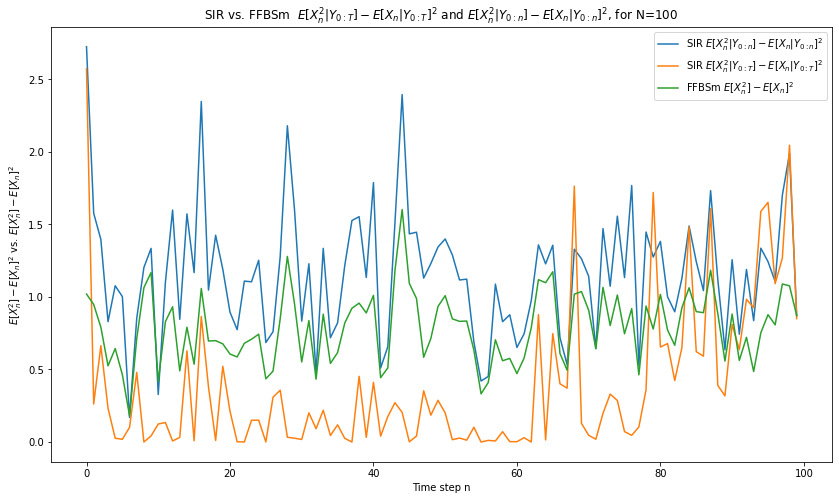

In [ ]:
# the expectations x 3 lines, plus the true X_n

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

#axs.plot(range(T), true_x, label = "True $x^*_{0:T}$",linewidth=1, color="black")
axs.plot(range(T), np.sum(q_SIR2 * (xu_SIR2**2), axis=0) - np.sum(q_SIR2 * xu_SIR2, axis=0)**2, label = "SIR $E[X^2_n|Y_{0:n}] - E[X_n|Y_{0:n}]^2$")
axs.plot(range(T), np.mean((x_SIR2**2), axis=0 ) -  np.mean(x_SIR2, axis=0 )**2, label = "SIR $E[X^2_n|Y_{0:T}] - E[X_n|Y_{0:T}]^2$")
axs.plot(range(T), np.sum(qq_FFBSm * (xu_SIR2**2), axis=0 ) - np.sum(qq_FFBSm * xu_SIR2, axis=0 )**2, label = "FFBSm $E[X^2_n] - E[X_n]^2$")

# Plot settings
axs.set_ylabel('$E[X^2_n] - E[X_n]^2$ vs. $E[X^2_n] - E[X_n]^2$')
axs.set_xlabel('Time step n')
plt.title("SIR vs. FFBSm  $E[X^2_n|Y_{0:T}] - E[X_n|Y_{0:T}]^2$ and $E[X^2_n|Y_{0:n}] - E[X_n|Y_{0:n}]^2$, for N=100")
plt.legend()

plt.savefig('Qs2_1_Var.png', dpi=300) ;

We can see smaller variance of FFBSm method, flat resampled SIR, with huge spikes towards the end of the timeline. And larger variance spikes in the SIR samples at time n. 

# Qs 2.2 Likelihood inference usign gradient ascent GradAS

Need to run the PF at each gradient descent iteration.

Here we want to compute the 

$$ I_n = \int \left[ \sum^T_{t=0} S_n(X^i_n, X^i_{n+1})\right] p(x_{0:n}|y_{0:n}) dx_{0:n} \\
\approx \sum^N_{i=1} W_n^i \left[ \sum^T_{t=0} S_n(X^i_n, X^i_{n+1})\right] $$

at each iteration of the GradAS method uding the either smoothing or particle filter weights.

The $log p_{\theta} (y_{0:n})$ can be calculated after each PF iteration - see variable ```log_rec```.

In [ ]:
NN = 500
TT = 100
# PF
x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=42, N = NN, T=TT, beta=0.5, sigma=1, rho = 0.91)
# FFBSm
qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = 0.91)


# The real 'max' of the log likelihood
np.cumsum(log_rec)[-1] # -238.4791 which is fine given the example plot in notes

# as rho goes to 1 the log-likelihood decreases, but as it goes to 0 the log-like decreases
# -438.0420 for rho = 0.99
# -145.2721 for rho = 0

-148.90094777187906

In [ ]:
np.log(np.exp(np.sum(log_rec))), np.sum(log_rec)

(-118.70958866079157, -118.70958866079157)

In [ ]:
n_iter = 50
step_size = 0.0001
tol = 1e-15

## PF and smoother
NN = 500
TT = 100
p = 0.6

def grad_asc_FFBSm(unknown_param, random_seed, step_size,  tol,  PF, FFBSm, n_iter= 50, NN = 500, TT = 100):

  new_loglike = 0

  for i in range(n_iter):

    old_loglike = new_loglike

    x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = PF(sd=random_seed, N = NN, T=TT, beta=0.5, sigma=1, rho = unknown_param)
    qq_FFBSm  = FFBSm(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = unknown_param)

    new_loglike = np.sum(log_rec)

    print("The negative log likelihood: ", new_loglike, r" for $\rho $ = ", unknown_param)

    # init gradient
    gradient = unknown_param * ((xu_SIR2[:,0]**2) + 1/(( unknown_param **2)-1) ) * qq_FFBSm[:,0]

    # gradient = 0
    for k in range(1,TT):
      gradient = gradient + x_SIR2[:,k-1] * ( xu_SIR2[:,k] - unknown_param * x_SIR2[:,k-1]) * qq_FFBSm[:,k]

    gradient = np.sum(gradient)

    # update p
    p = p + step_size * gradient

    if p > 1:
      break 

    #if (old_loglike - new_loglike) < tol:
    #  break

Decided to run the gradient descent outside the definition.

In [ ]:
new_loglike = 0
n_iter = 500
step_size = 0.0001
tol = 1e-09

## PF and smoother
NN = 100
TT = 100
unknown_param = 1.2
p_param13 = np.zeros(n_iter)
#print(p_param2.shape)
p_param13[0] = unknown_param

random_seed = 42

for ind in range(n_iter):

  old_loglike = new_loglike

  x_SIR2, xu_SIR2, q_SIR2, qq_SIR2, I, log_rec = optimal_SIR(sd=random_seed, N = NN, T=TT, beta=0.5, sigma=1, rho = unknown_param)
  qq_FFBSm  = FFBSm_optimal(xu_SIR2, q_SIR2, beta=0.5, sigma=1, rho = unknown_param)

  new_loglike = np.sum(log_rec)
  print("Iteration ",ind)
  print("The negative log likelihood: ", new_loglike, r" for $\rho $ = ", unknown_param)

  # init gradient
  gradient = 0
  gradient = (unknown_param * ((xu_SIR2[:,0]**2) + 1/(( unknown_param **2)-1) ) ) * qq_FFBSm[:,0]

  # gradient = 0
  for time in range(1,TT):
    gradient = gradient + x_SIR2[:,time-1] * ( xu_SIR2[:,time] - unknown_param * x_SIR2[:,time-1]) * qq_FFBSm[:,time]

  gradient = np.sum(gradient)
  print("The gradient: ",gradient)

  # update p
  unknown_param = unknown_param + step_size * gradient
  p_param13[ind] = unknown_param

  if unknown_param > 1:
    break 

  if abs(old_loglike - new_loglike) < tol:
    print("Reached tolerance")
    break

ValueError: ignored

0.8831629361462441
0.8844586801714714
0.8931086055495198


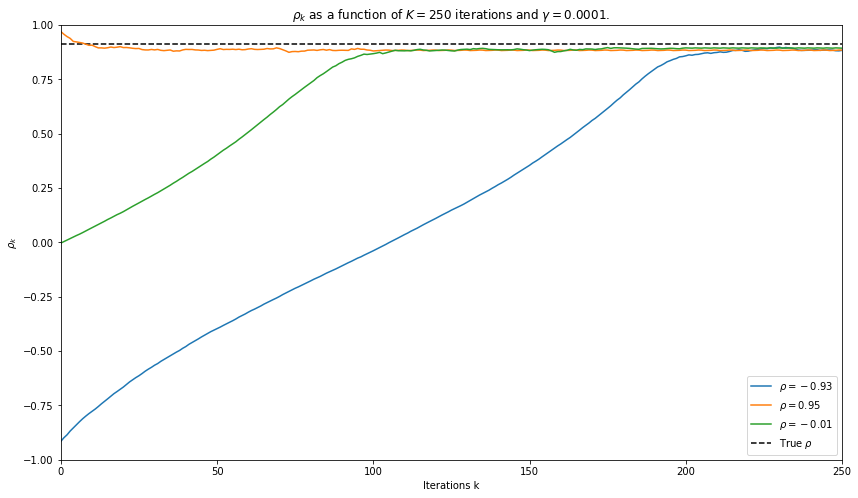

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

axs.plot(p_param11[np.nonzero(p_param11)], label=r"$\rho = -0.93$")
print(p_param11[-1])
axs.plot(p_param12[np.nonzero(p_param12)], label=r"$\rho = 0.95$")
print(p_param12[-1])
axs.plot(p_param13[np.nonzero(p_param13)], label=r"$\rho =-0.01$")
print(p_param13[-1])

axs.hlines(y=0.91, xmin=0, xmax = 500, label = r"True $\rho $", linestyle='dashed')
plt.ylim(-1,1)
plt.xlim(0,250)

plt.xlabel("Iterations k")
plt.ylabel(r"$\rho_k$")
plt.title(r"$\rho_k$ as a function of $K = 250$ iterations and $ \gamma = 0.0001$.")
plt.legend()

plt.savefig('qs2_2_log_likelihood_2.png', dpi=300) 

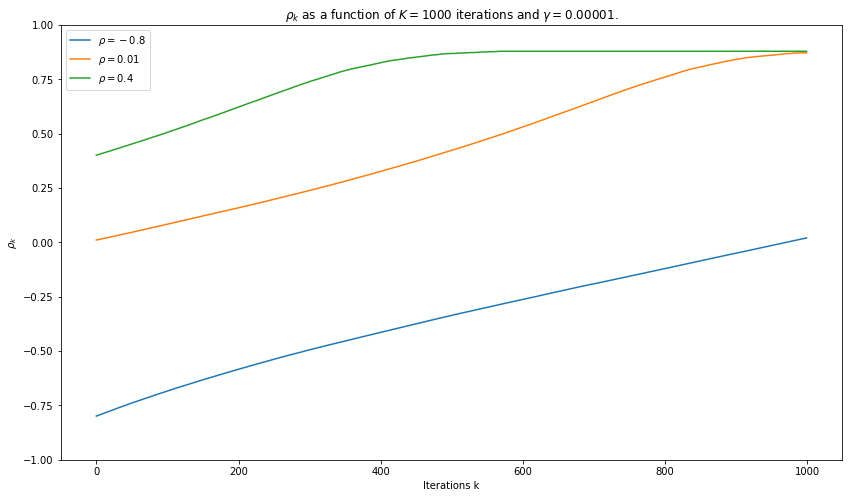

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

axs.plot(p_param1[np.nonzero(p_param1)], label=r"$\rho = -0.8$")
axs.plot(p_param2[np.nonzero(p_param2)], label=r"$\rho = 0.01$")
axs.plot(p_param5[np.nonzero(p_param5)], label=r"$\rho = 0.4$")
plt.ylim(-1,1)
plt.xlabel("Iterations k")
plt.ylabel(r"$\rho_k$")
plt.title(r"$\rho_k$ as a function of $K = 1000$ iterations and $ \gamma = 0.00001 $.")
plt.legend()

plt.savefig('qs2_2_log_likelihood.png', dpi=300) 

# Question 3

Gaussian linear model

$$ X_n = \rho X_{n-1} + \tau V_n $$

$$ Y_n = X_n + \sigma W_n $$

where we have the following parameters that give the model:


$$ X_n = 0.8 X_{n-1} +  V_n $$

$$ Y_n = X_n + 0.5 W_n $$

## Part 1 The ideal Marginal MH with Kalman Filter 

Prior for $\rho \sim U(-1,1)$, and for $\tau \sim IGa(1,1) $

With two MCMC diagnostics:

- acceptance ratio
- ESS
- ACF decay
Assess mixing by traceplots ... with 20,000 plots, or just use expected square jumping distance.

In [ ]:
# model params
rho = 0.8
sigma = 0.5
tau = 1

T=100 # Number of time steps.

# Initial state/ Set up
x0 = 0.0 
true_x = np.zeros((T,1))   # Hidden states.
y = np.zeros((T,1))        # Observations.
true_x[0,:] = x0      # Initial state.   
V = np.random.normal(size = (T,1))  # hidden state noise
W = np.random.normal(size = (T,1))  # observations noise

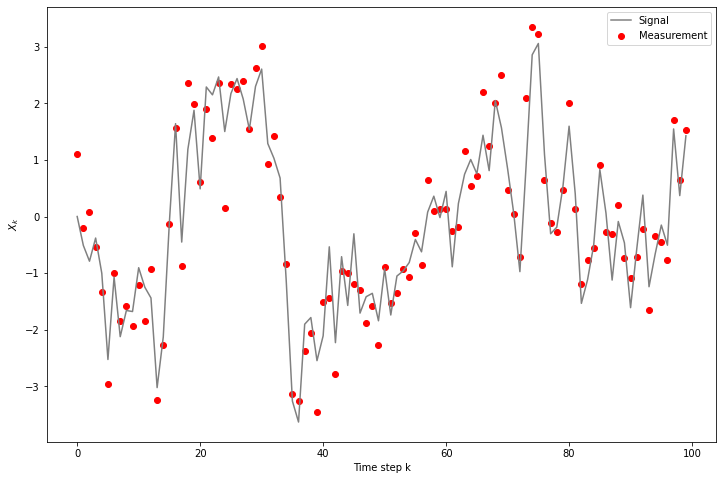

In [ ]:
# GENERATE TRUE STATE AND MEASUREMENTS:

y[0] = true_x[0] + sigma*V[0] 

for t in range(1,T):
  true_x[t] = rho*true_x[t-1] + tau*W[t] # tau = srt(Q) =1
  y[t] = true_x[t] + sigma*V[t]  # sqrt(R)

fig, axs = plt.subplots(1, 1, figsize=(12,8) )

axs.plot(range(T), true_x, label = "Signal", color="grey")
axs.set_ylabel('$X_k$')
axs.set_xlabel('Time step k')
axs.scatter(range(T), y, label = "Measurement", color="red")
plt.legend();

In [ ]:
def Kalman_Filter(T, x0, initVar, data, rho = 0.8, tau = 1, sigma=0.5,  c=1 ):
  # Storage
  RecLikeMean=np.zeros((T,1))
  RecLikeVar=np.zeros((T,1))
  mu=np.zeros((T,1))
  Sigma=np.zeros((T,1))

  # mean and variance initial
  mu_pred=x0# mu = x0
  SigmaPred=initVar 

  # setting initial states
  RecLikeMean[0] = c*mu_pred # m_o
  RecLikeVar[0] = (c**2)*SigmaPred + sigma**2 # S_o *here sigma = 0.1

  z = data[0] - c*mu_pred  # (y _n - c*m_n)
  K = c*SigmaPred * (1/RecLikeVar[0]) # inverse of S_o

  # mu_1 and var_1 given n=1
  mu[0] = mu_pred+K*z
  Sigma[0]=(1-K*c)*SigmaPred

  for t in range(1,T):

    mu_pred=rho*mu[t-1,:] # a=rho=0.8
    SigmaPred=(rho**2)*Sigma[t-1] + (tau)**2 # b = tau

    z = data[t]-c*mu_pred
    SS = (c**2)*SigmaPred + sigma**2 # d = sigma = 0.5 fixed/known

    RecLikeMean[t] = c*mu_pred
    RecLikeVar[t] = SS

    K = SigmaPred* c *(1/SS) #Kalman gain

    mu[t] = mu_pred + K*z
    Sigma[t] = (1-K*c)*SigmaPred

  # rec likelihood
  rec_true = norm.pdf(data, loc= RecLikeMean, scale=np.sqrt(RecLikeVar))
  return mu, Sigma, rec_true

In [ ]:
from scipy.stats import norm, invgamma, expon, uniform , multivariate_normal

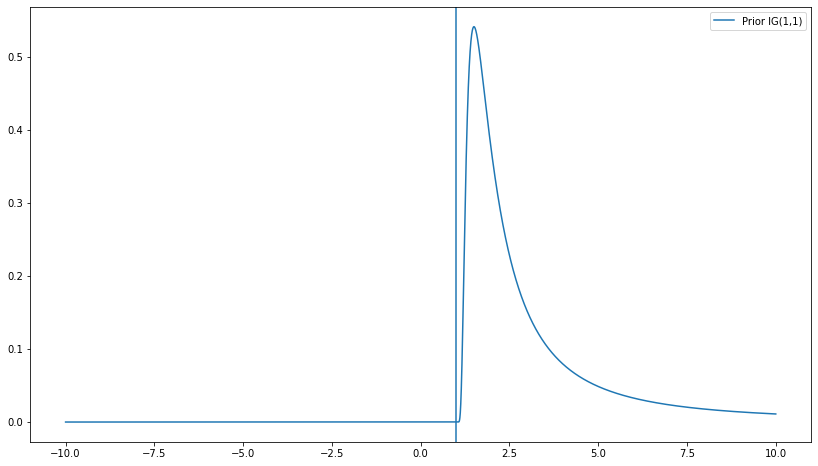

In [ ]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-10, 10, 0.001)

fig, axs = plt.subplots(1, 1, figsize=(14,8) )
# PDFs
#plt.plot(x_axis, norm.pdf(x_axis,0,1), label="normal")
plt.plot(x_axis, invgamma.pdf(x_axis,1,1), label="Prior IG(1,1)")
#plt.plot(x_axis, uniform.pdf(x_axis,loc=-1, scale=2), label="Prior Uni(-1,1)")
#plt.plot(x_axis, expon.pdf(x_axis,1), label="Exp")
plt.axvline(x=1)
#plt.axvline(x=-1)
plt.legend()
plt.show()

In [ ]:
# Random walk proposal Metropolis Hastings

def KF_likeli(rec_KF):
  return np.exp(np.sum(np.log(rec_KF)))

# Asume two parameters are independent of each other
def prior_indep(tau_1, rho_1):
  prob1 = invgamma.pdf(tau_1,1,1)
  prob2 = uniform.pdf(rho_1, loc=-1, scale=2)
  return prob1*prob2

def proposal_eval(tau_1, tau_mean, rho_1, rho_mean,  tau_sigma = 1, rho_sigma = 1):
  prob1 = norm.pdf(rho_1, rho_mean, rho_sigma)
  prob2 = norm.pdf(tau_1, tau_mean, tau_sigma)
  return prob1*prob2

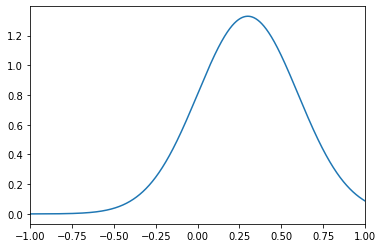

In [ ]:
plt.plot(x_axis, norm.pdf(x_axis,0.3,0.3), label="normal")
plt.xlim([-1,1]);

### M-H KF

In [ ]:
naccept = 0
np.random.seed(seed=42)
tau = np.random.normal(0, 0.5)
tau_sigma = 0.1
rho = np.random.normal(0, 0.5)
rho_sigma = 0.1
niters = 200
samples = np.zeros((niters+1,2))
theta = np.array([tau, rho])
samples[0,:] = theta
__, __, rec_KF = Kalman_Filter(T=100, x0=0, initVar=1, data=y, rho = rho, tau = tau)

for i in range(niters):

    # sampling theta 
    tau_new = np.random.normal(tau, tau_sigma)
    rho_new = np.random.normal(rho, rho_sigma)

    while tau_new < 0:
      tau_new = np.random.normal(tau, tau_sigma)
    #print(tau_new)

    while rho_new < -1 or rho_new > 1:
      rho_new = np.random.normal(rho, rho_sigma)
    #print(tau_new, rho_new)
    #print(i, tau_new, prior_indep(tau_new, rho_new)/prior_indep(tau, rho) )

    # likelihood y given theta with Kalman FIlter
    __, __, rec_KF_new = Kalman_Filter(T=100, x0=0, initVar=1, data=y, rho = rho_new, tau = tau_new)

    ratio = ( KF_likeli(rec_KF_new) * prior_indep(tau_new, rho_new) )  / ( KF_likeli(rec_KF) * prior_indep(tau, rho))
    print(i, tau_new, ratio)

    alpha = min(1,  ratio )

    u = np.random.uniform()

    if u < alpha:
        naccept += 1
        tau = tau_new
        rho = rho_new
        rec_KF = rec_KF_new
    
    theta = np.array([tau, rho])
    samples[i+1,:] = theta

nmcmc = len(samples)//2
burnin = 2000
print( "Efficiency = ", naccept/niters)

print("tau mean",np.mean(samples[1000:, 0]))
print("rho mean",np.mean(samples[1000:, 1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


0 0.3131259303156856 nan
1 0.34103005953569937 nan
2 0.29408262094220416 nan
3 0.23694460436679002 nan
4 0.06445282111548672 nan
5 0.021648214697863273 nan
6 0.16821309159001868 nan
7 0.42416189469379795 nan
8 0.30906253695156766 nan
9 0.24903715194097648 nan
10 0.1888664907180368 nan
11 0.1355016103337881 nan
12 0.21775610154410702 nan
13 0.49558740569935106 nan
14 0.5694340636988922 nan
15 0.4685255294123814 nan
16 0.42246165231640265 nan
17 0.30940642184824596 nan
18 0.24171422181765007 nan
19 0.299926501288954 nan
20 0.21600474896669014 nan
21 0.06518942001194186 nan
22 0.14644200225136167 nan
23 0.28206600510844393 nan
24 0.27448563060562536 nan
25 0.42828928725222226 nan
26 0.33625020674548467 nan
27 0.3063494716988979 nan
28 0.3082495048051129 nan
29 0.2564224829777481 nan
30 0.21373560357377583 nan
31 0.35092181692875346 nan
32 0.28071650754101823 nan
33 0.40808986955497384 nan
34 0.40860121521921994 nan
35 0.3690495700611906 nan
36 0.35292099889458967 nan
37 0.2586153180478634

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


1.2868745914110276 1.5296233476703327
124 1.385225022046874 0.216918331477987
125 1.2095736130254808 0.8671525206466316
126 1.4248918587766366 0.1678364406018777
127 1.1984804194625298 0.08431231284458222
128 1.1256014288074032 0.4041568403488441
129 1.3128336534272784 0.6928473185712154
130 1.3470092510049945 0.4105603110893812
131 1.4041440020376732 0.040017278083202365
132 1.2149859303029302 0.12098020476491823
133 1.300091685794524 1.073592368015363
134 1.190357098937858 1.9070949406476794
135 1.314138730135204 0.687398300158506
136 1.1848086031080907 0.9449986000140775
137 1.189506662484565 1.8125551362301644
138 1.0295943152308167 2.396737239640354e-11
139 1.2409505458904397 0.08311018545728308
140 1.3436437621763833 0.20678487288408415
141 1.1146580088289095 0.12262038961055079
142 1.344632947957862 0.49649956596316874
143 1.4417900430532975 0.007515899431515236
144 1.4324154648058733 0.029971856277215814
145 1.1687589993155507 0.4231089237812644
146 1.1550512172113654 0.6317883

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Histograms 3.1

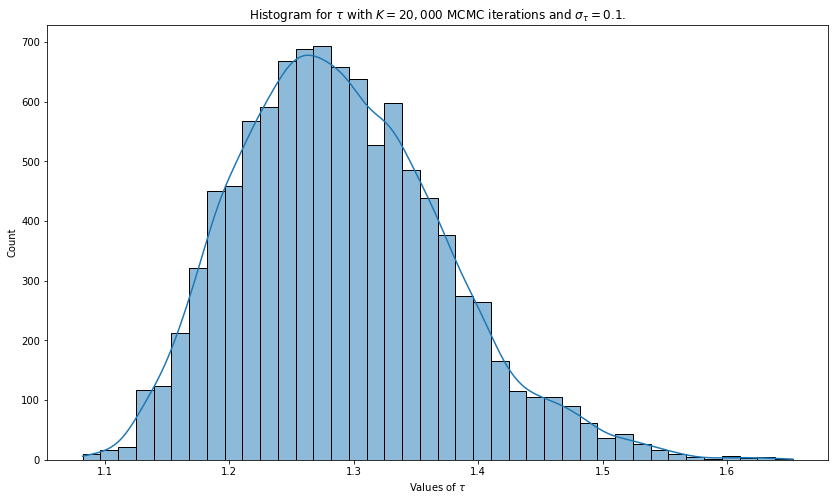

In [ ]:
# Histogram of tau

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

num_bins = 40
#n, bins, patches = plt.hist(samples[nmcmc:, 1], num_bins, facecolor='blue', alpha=0.5)
hist_plot_tau = sns.histplot(ax = axs, data=samples[nmcmc:, 0],bins = num_bins,  kde=True)
# plt.ylim(-1,1)
# plt.xlim(0,250)

plt.xlabel(r"Values of $\tau $")
#plt.ylabel(r"$\rho_k$")
plt.title(r"Histogram for $\tau$ with $K = 20,000$ MCMC iterations and $ \sigma_{\tau} = 0.1 $.")
plt.show()

#fig = hist_plot_tau.get_figure()
#fig.savefig('qs3_1_tau_hist.png', dpi=300) 

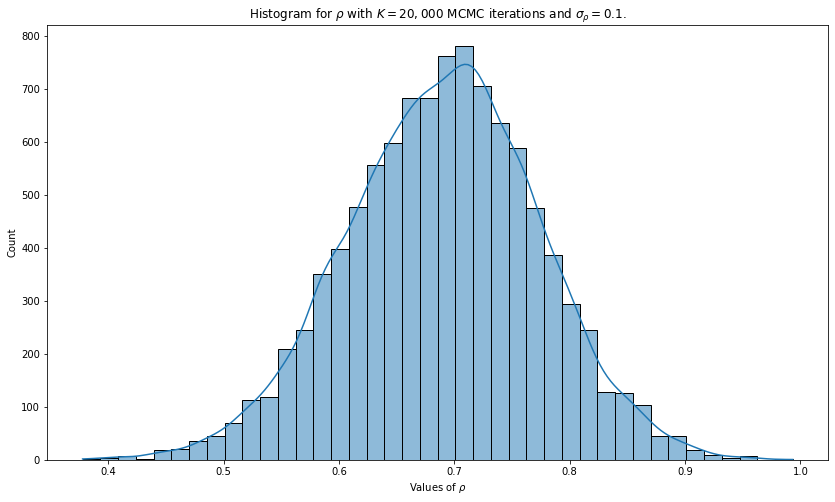

In [ ]:
# Histogram of rho

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

num_bins = 40
#n, bins, patches = plt.hist(samples[nmcmc:, 1], num_bins, facecolor='blue', alpha=0.5)
hist_plot = sns.histplot(ax= axs , data=samples[nmcmc:, 1],bins = num_bins,  kde=True)

plt.xlabel(r"Values of $\rho $")
#plt.ylabel(r"$\rho_k$")
plt.title(r"Histogram for $\rho$ with $K = 20,000$ MCMC iterations and $ \sigma_{\rho} = 0.1 $.")
plt.show()
#fig = hist_plot.get_figure()
#fig.savefig('qs3_1_rho_hist.png', dpi=300) 

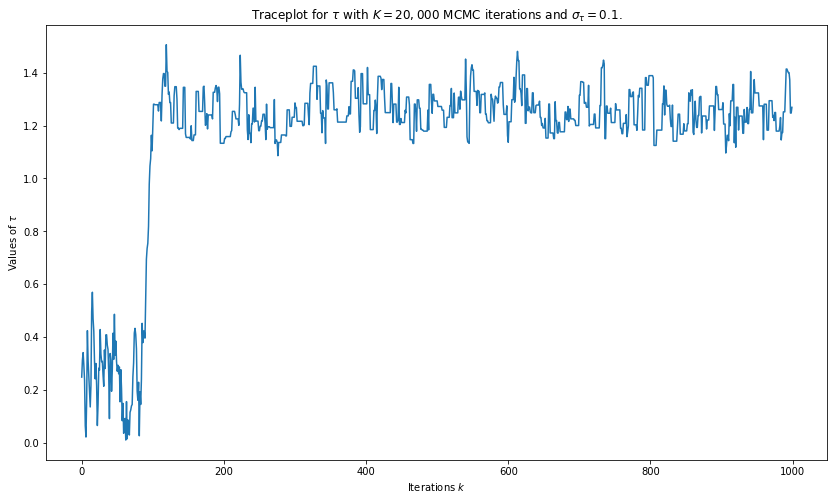

In [ ]:
# Traceplot of tau
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

plt.plot(samples[:1000, 0])
# plt.ylim(-1,1)
# plt.xlim(0,250)

plt.xlabel(r"Iterations $k$")
plt.ylabel(r"Values of $\tau $")
plt.title(r"Traceplot for $\tau$ with $K = 20,000$ MCMC iterations and $ \sigma_{\tau} = 0.1 $.")
plt.show()

#fig.savefig('qs3_1_tau_traceplot.png', dpi=300) 

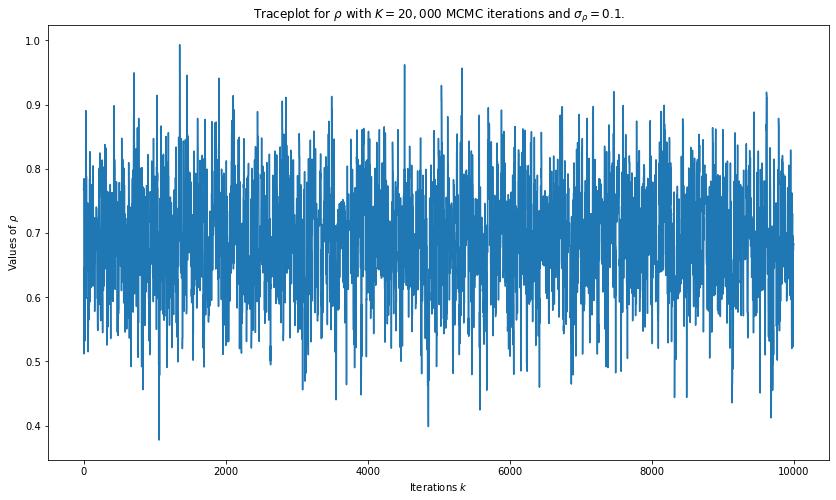

In [ ]:
# Traceplot of tau
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

plt.plot(samples[nmcmc:, 1])
# plt.ylim(-1,1)
# plt.xlim(0,250)

plt.xlabel(r"Iterations $k$")
plt.ylabel(r"Values of $\rho $")
plt.title(r"Traceplot for $\rho$ with $K = 20,000$ MCMC iterations and $ \sigma_{\rho} = 0.1 $.")
plt.show()

#fig.savefig('qs3_1_rho_traceplot.png', dpi=300) 

In [ ]:
print(r"$\hat{\rho}$ ", np.mean(samples[nmcmc:, 1]))
print(r"$\hat{\tau}$ ", np.mean(samples[nmcmc:, 0]))

print(r"Var $\hat{\rho}$ ", np.var(samples[nmcmc:, 1]))
print(r"Var $\hat{\tau}$ ", np.var(samples[nmcmc:, 0]))

$\hat{\rho}$  0.6902251576626248
$\hat{\tau}$  1.290218933222337
Var $\hat{\rho}$  0.006887749279757276
Var $\hat{\tau}$  0.006917148992003632


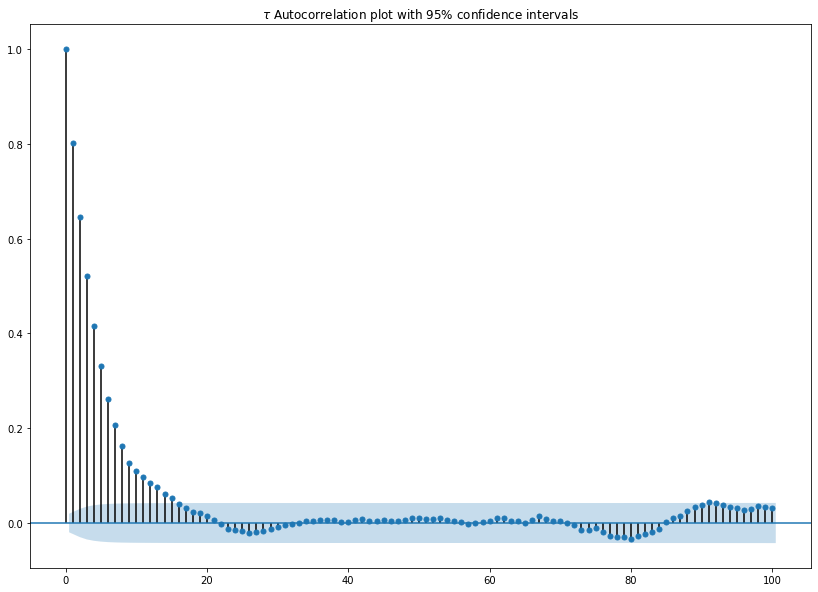

In [ ]:
# AC Plot
fig, axs = plt.subplots(1, 1, figsize=(14,10))

plot_acf(samples[nmcmc:, 0], ax=axs, lags=100, title=r"$ \tau $ Autocorrelation plot with 95% confidence intervals")
plt.show()

#fig = acf_plot.get_figure()
fig.savefig('qs3_1_tau_acft.png', dpi=300) 

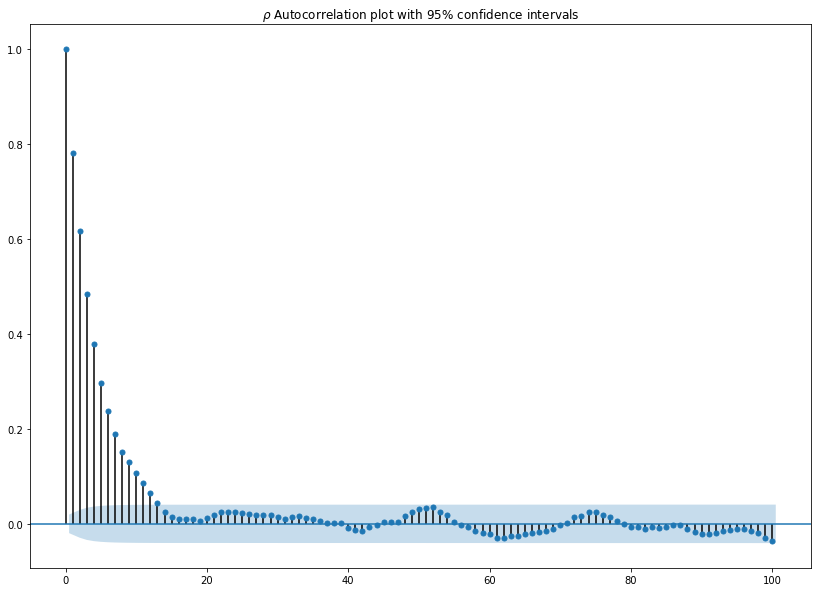

In [ ]:
# AC Plot
fig, axs = plt.subplots(1, 1, figsize=(14,10))
plot_acf(samples[nmcmc:, 1],ax=axs, lags=100, title=r"$ \rho $ Autocorrelation plot with 95% confidence intervals")
plt.show()

fig.savefig('qs3_1_rho_acft.png', dpi=300) 

In [ ]:
nmcmc

10000

### Other plots

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

hist, xedges, yedges = np.histogram2d(samples[1000:, 0], samples[1000:, 1], bins=100, range=[[0, 2], [0, 2]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] , yedges[:-1] , indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

# ax.bar3d?
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

https://stats.stackexchange.com/questions/447665/how-to-compute-ess-effective-sample-size ESS


https://oriolabril.github.io/arviz/api/generated/arviz.ess.html 

In [ ]:
## ESS three methods of working it out
def neff(arr):
    n = len(arr)
    acf = autocorr(arr, nlags=n, fft=True)
    sums = 0
    for k in range(1, len(acf)):
        sums = sums + (n-k)*acf[k]/n

    return n/(1+2*sums)

print(neff(samples[:, 0]))

def neff_other(arr):
    n = len(arr)
    acf = autocorr(arr, nlags=n, fft=True)
    sums = 0
    for k in range(1, len(acf)):
        sums = sums + (n-k)*acf[k]/(n-1)

    return n/(1+2*sums)

print(neff_other(samples[:, 0]))

In [ ]:
import arviz as az
az.ess(samples[:, 0])

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
tfp.mcmc.effective_sample_size(samples[:, 0])

## Part 2: Particle Marginal MH

Same MCMC design but with a Particle filter, off-line method too.

In [ ]:
def SIR_opt( rho =0.8, tau = 1, sigma = 0.5, initVar=1, N=500, sd = 42, T=100, c =1):
  # np.random.seed(seed=sd)
  # filtering approx
  x_SIR2 =np.zeros((N,T))
  # prediction approx
  xu_SIR2 =np.zeros((N,T))
  # normalised weights
  q_SIR2 =np.zeros((N,T))
  # unormalised weights
  qq_SIR2=np.zeros((N,T))

  R = sigma**2
  Q = tau**2

  # log of weights for ease of computation
  log_w=np.zeros((N,T))

  # ancestors index
  I = np.zeros((N,T))
  log_rec=np.zeros((T,1))

  # Opt proposal statistics

  S=( 1/(tau**2) + c*( 1/(sigma**2) )*c )**(-1)
  mu_prop_offset= S* ( c*( (1/(sigma**2))*y ) )
  mu_prop_gain=(S)*( 1/(tau**2) )*rho

  # S, mu_prop_gain , mu_prop_offset.shape

  # INIT: SAMPLE FROM THE PRIOR:
  x0 = 0
  xu_SIR2[:,0:1] = x0 + np.sqrt(initVar)*np.random.normal(0,1,size=(N,1))
  # qq_SIR = np.zeros((N,T)) # unnormalised weights
  m = c*xu_SIR2[:,0]

  # the initial unnormalised weights
  qq_SIR2[:,0] = np.exp(-0.5* R**(-1)*(y[0]- m)**(2))/(np.sqrt(2*np.pi*R))
  # normalised weights
  q_SIR2[:,0] = qq_SIR2[:,0]/np.sum(qq_SIR2[:,0])

  # resampling STEP
  # I(:,1)=randsample(1:N,N,true,q_SIR(:,1));
  I[:,0] = np.random.choice( list(range(N)) , N, replace=True, p = q_SIR2[:,0] )
  #print(np.max(I[:,0]) , np.min(I[:,0]))

  # resampled Xhat values
  x_SIR2[:,0] = xu_SIR2[ I[:,0].astype('int32').tolist() ,0]
  log_rec[:,0]=np.log(np.mean( qq_SIR2[:,0] ))

  # UPDATE AND PREDICTION STAGES:
  for t in range(T-1):

    #print(t)

    xu_SIR2[:,t+1:t+2] = mu_prop_offset[t+1]*np.ones((N,1)) + mu_prop_gain*x_SIR2[:,t:t+1] + np.sqrt(S)*np.random.normal(0,1,size=(N,1))

    #print(xu_SIR2)
    # log of weights
    log_w[:,t+1] = -0.5*(1/R)*(y[t+1]- c*xu_SIR2[:,t+1])**2 -0.5*(1/Q)*( xu_SIR2[:,t+1] - rho * x_SIR2[:,t] )**2 + 0.5*(1/S)*( xu_SIR2[:,t+1] - mu_prop_offset[t+1] - mu_prop_gain*x_SIR2[:,t] )**2 - np.log(np.sqrt(2*np.pi*R)) - np.log(np.sqrt(2*np.pi*Q)) + np.log(np.sqrt(2*np.pi*S))

    # implementing log exp sum trick for weights
    offset=np.max(log_w[:,t+1])
    log_w[:,t+1] = log_w[:,t+1] - offset

    qq_SIR2[:,t+1] = np.exp(log_w[:,t+1])
    q_SIR2[:,t+1] = qq_SIR2[:,t+1]/sum(qq_SIR2[:,t+1])

    log_rec[:,t+1:t+2] = np.log(np.mean( qq_SIR2[:,t+1] ) ) + offset

    # sampler offsprings
    I[:,t+1] = np.random.choice( list(range(N)) , N, replace=True, p = q_SIR2[:,t+1] )
    x_SIR2[:,t+1] = xu_SIR2[ I[:,t+1].astype('int32').tolist() ,t+1]
    x_SIR2[:, :t] = x_SIR2[ I[:,t+1].astype('int32').tolist(), :t ]

  return log_rec, xu_SIR2, x_SIR2, qq_SIR2, q_SIR2

0
[[ 0.49671415 -0.36583484  0.         ...  0.          0.
   0.        ]
 [-0.1382643  -0.049611    0.         ...  0.          0.
   0.        ]
 [ 0.64768854  0.24885551  0.         ...  0.          0.
   0.        ]
 ...
 [-0.19033868 -0.09710682  0.         ...  0.          0.
   0.        ]
 [-0.87561825 -0.30963129  0.         ...  0.          0.
   0.        ]
 [-1.38279973 -0.09184972  0.         ...  0.          0.
   0.        ]]
1
[[ 0.49671415 -0.36583484  1.38160143 ...  0.          0.
   0.        ]
 [-0.1382643  -0.049611    1.01216158 ...  0.          0.
   0.        ]
 [ 0.64768854  0.24885551  1.63054613 ...  0.          0.
   0.        ]
 ...
 [-0.19033868 -0.09710682  0.88554501 ...  0.          0.
   0.        ]
 [-0.87561825 -0.30963129  1.22371045 ...  0.          0.
   0.        ]
 [-1.38279973 -0.09184972  1.57077311 ...  0.          0.
   0.        ]]
2
[[ 0.49671415 -0.36583484  1.38160143 ...  0.          0.
   0.        ]
 [-0.1382643  -0.049611    1.0121

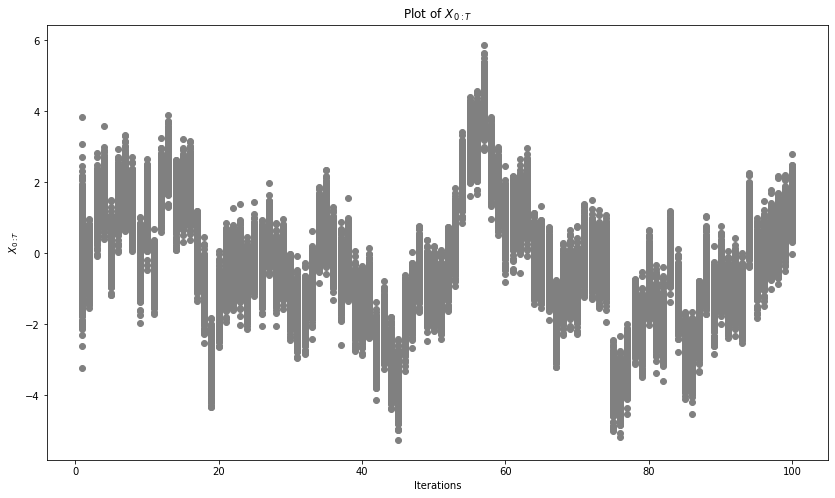

In [ ]:
log_rec, xu_SIR2, x_SIR2, qq_SIR2, q_SIR2 = SIR_opt( rho =0.8, tau = 1, sigma = 0.5, initVar=1, N=500, sd = 42, T=100, c =1)

# Plot of X with true parameters

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

for num in range(500):
  plt.scatter(np.arange(1, 101, 1), xu_SIR2[num,:], c="grey")

plt.xlabel(r"Iterations")
plt.ylabel(r"$X_{0:T}$")
plt.title(r"Plot of $X_{0:T}$")
plt.show()

PF -168.43681770213095
 
KF -164.25047404300116


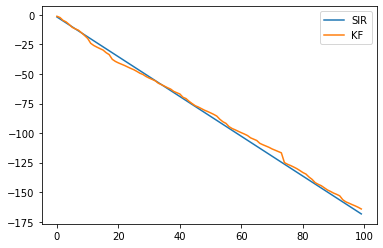

In [ ]:
log_rec, xu_SIR2, x_SIR2, qq_SIR2, q_SIR2 = SIR_opt( rho =0.8, tau = 1, sigma = 0.5, initVar=4, N=500, sd = 42, T=100, c =1)

print("PF", np.sum(log_rec))
print(" ")

mu, Sigma, rec_true = Kalman_Filter(T=100, x0=0, initVar=1, data=y, rho = 0.8, tau = 1, sigma=0.5,  c=1 )
print("KF", np.sum(np.log(rec_true)))

plt.plot(np.cumsum(log_rec), label="SIR")
plt.plot(np.cumsum(np.log(rec_true)), label="KF")
plt.legend()
plt.show()

In [ ]:
# Random walk proposal Metropolis Hastings

def SIR_likeli(log_rec):
  return np.exp(np.sum(log_rec))

# Asume two parameters are independent of each other
def prior_indep(tau_1, rho_1):
  prob1 = invgamma.pdf(tau_1,1,1)
  prob2 = uniform.pdf(rho_1, loc=-1, scale=2)
  return prob1*prob2

def proposal_eval(tau_1, tau_mean, rho_1, rho_mean,  tau_sigma = 1, rho_sigma = 1):
  prob1 = norm.pdf(rho_1, rho_mean, rho_sigma)
  prob2 = norm.pdf(tau_1, tau_mean, tau_sigma)
  return prob1*prob2

In [ ]:
naccept = 0
#np.random.seed(seed=42)
tau = 2 # np.random.normal(0, 0.07)
tau_sigma = 0.1
rho = 0.9 #np.random.normal(0, 0.97)
rho_sigma = 0.1
niters = 20000
samples_SIR3 = np.zeros((niters+1,2))
theta = np.array([tau, rho])
samples_SIR3[0,:] = theta
log_rec, __, __, __, __ = SIR_opt( rho = rho, tau = tau, sigma = 0.5, initVar=4, N=700)

for i in range(niters):

  print(i)

  # sampling theta 
  tau_new = np.random.normal(tau, tau_sigma)
  rho_new = np.random.normal(rho, rho_sigma)

  # while tau_new < 0.9:
  #   tau_new = np.random.normal(tau, tau_sigma)

  # while rho_new < -1 or rho_new > 1:
  while abs(rho_new) > 1:
    rho_new = np.random.normal(rho, rho_sigma)

  # likelihood y given theta with SIR
  log_rec_new, __, __, __, __ = SIR_opt( rho = rho_new, tau = tau_new, sigma = 0.5, initVar=4, N=700)
  

  ratio = ( SIR_likeli(log_rec_new) * prior_indep(tau_new, rho_new) )  / ( SIR_likeli(log_rec) * prior_indep(tau, rho))
  print(i,rho_new, tau_new,  ratio)

  alpha = min(1,  ratio )

  u = np.random.uniform()

  if u < alpha:
    naccept += 1
    tau = tau_new
    rho = rho_new
    log_rec = log_rec_new
  
  theta = np.array([tau, rho])
  samples_SIR3[i+1,:] = theta

nmcmc = len(samples_SIR3)//2
burnin = 2000
print( "Efficiency = ", naccept/niters)

print("tau mean",np.mean(samples_SIR3[nmcmc:, 0]))
print("rho mean",np.mean(samples_SIR3[nmcmc:, 1]))

Streaming output truncated to the last 5000 lines.
17501 0.9038517342338436 1.8292258451776555 9.460546225950624e-11
17502
17502 0.9053162965671611 1.9125308925603337 4.748699754291956e-13
17503
17503 0.832622108294245 1.6538105737097961 1.1361392992668957e-08
17504
17504 0.9723511846217495 1.6865024524858918 7.37886286563272e-05
17505
17505 0.8528829088833223 1.681558966327589 2.214539866745642e-09
17506
17506 0.8195130299841155 1.7354738121023943 1.4597610184496227e-06
17507
17507 0.9190007321098064 1.620462613420599 6.220589220880457e-09
17508
17508 0.927531488266393 1.6240975417667993 2.8589965577149924e-10
17509
17509 0.8593324525537362 1.756685280961624 2.8735036519614357e-10
17510
17510 0.9049205976202888 1.6814106716870487 1.593312475666864e-05
17511
17511 0.7714822343650332 1.5372622651923582 2.771034967950702e-07
17512
17512 0.9891269106097822 1.7220850153302447 6.829443609258621e-09
17513
17513 0.8253317844606995 1.7254360342066268 6.08346135098986e-12
17514
17514 0.97678487

### SIR plots

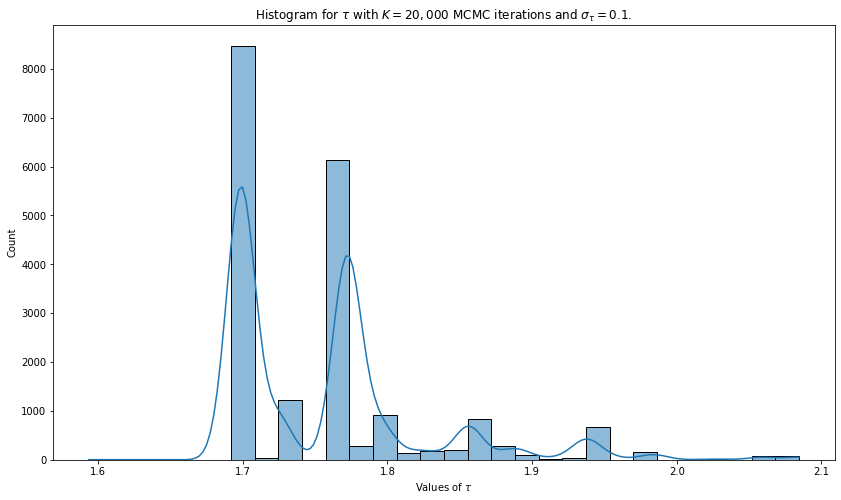

In [ ]:
# Histogram of tau

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

num_bins = 30
#n, bins, patches = plt.hist(samples[nmcmc:, 1], num_bins, facecolor='blue', alpha=0.5)
hist_plot_tau = sns.histplot(ax = axs, data=samples_SIR3[100:, 0],bins = num_bins,  kde=True)
# plt.ylim(-1,1)
# plt.xlim(1.6,2)
# axs.plot(grid_tau, pdf_tau )

plt.xlabel(r"Values of $\tau $")
#plt.ylabel(r"$\rho_k$")
plt.title(r"Histogram for $\tau$ with $K = 20,000$ MCMC iterations and $ \sigma_{\tau} = 0.1 $.")
plt.show()

fig = hist_plot_tau.get_figure()
fig.savefig('qs3_2_tau_hist.png', dpi=300) 

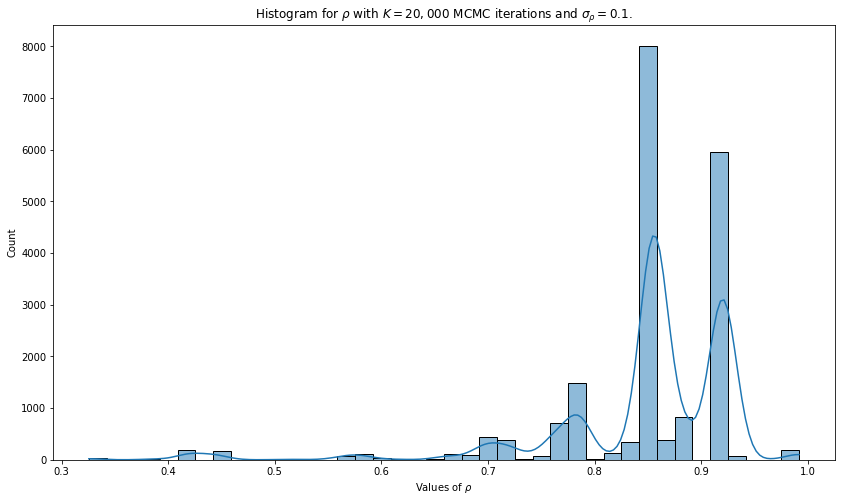

In [ ]:
# Histogram of rho

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

num_bins = 40
#n, bins, patches = plt.hist(samples[nmcmc:, 1], num_bins, facecolor='blue', alpha=0.5)
hist_plot = sns.histplot(ax= axs , data=samples_SIR3[100:, 1],bins = num_bins,  kde=True)

plt.xlabel(r"Values of $\rho $")
#plt.ylabel(r"$\rho_k$")
plt.title(r"Histogram for $\rho$ with $K = 20,000$ MCMC iterations and $ \sigma_{\rho} = 0.1 $.")
plt.show()

fig = hist_plot.get_figure()
fig.savefig('qs3_2_rho_hist.png', dpi=300) 

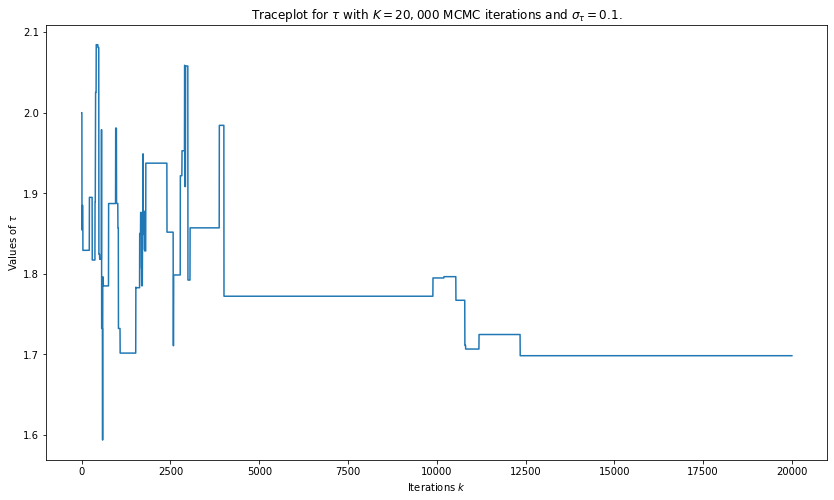

In [ ]:
# Traceplot of tau
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

plt.plot(samples_SIR3[:, 0])
# plt.ylim(-1,1)
# plt.xlim(0,250)

plt.xlabel(r"Iterations $k$")
plt.ylabel(r"Values of $\tau $")
plt.title(r"Traceplot for $\tau$ with $K = 20,000$ MCMC iterations and $ \sigma_{\tau} = 0.1 $.")
plt.show()

fig.savefig('qs3_2_tau_traceplot.png', dpi=300) 

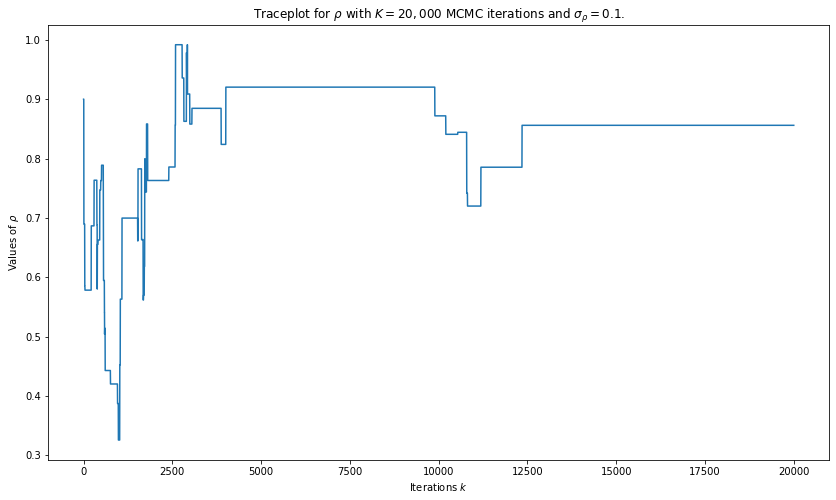

In [ ]:
# Traceplot of tau
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

plt.plot(samples_SIR3[:, 1])
# plt.ylim(-1,1)
#plt.xlim(0,250)

plt.xlabel(r"Iterations $k$")
plt.ylabel(r"Values of $\rho $")
plt.title(r"Traceplot for $\rho$ with $K = 20,000$ MCMC iterations and $ \sigma_{\rho} = 0.1 $.")
plt.show()

fig.savefig('qs3_2_rho_traceplot.png', dpi=300) 

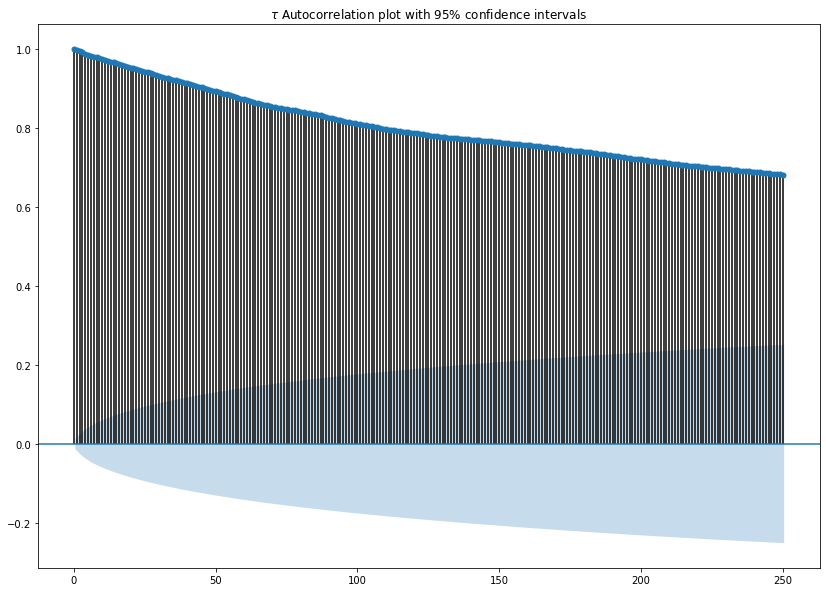

In [ ]:
# AC Plot
fig, axs = plt.subplots(1, 1, figsize=(14,10))

plot_acf(samples_SIR3[100:, 0], ax=axs, lags=250, title=r"$ \tau $ Autocorrelation plot with 95% confidence intervals")
plt.show()

fig.savefig('qs3_2_tau_acft.png', dpi=300) 

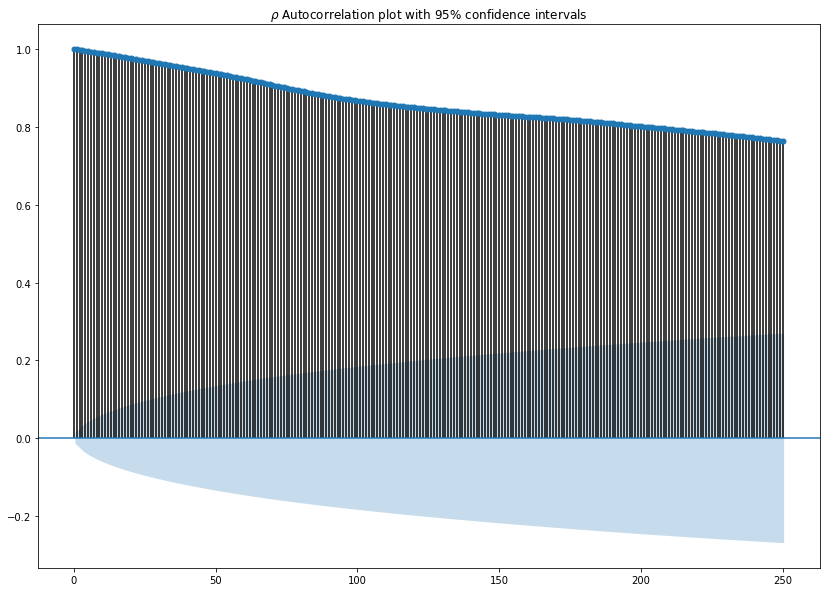

In [ ]:
# AC Plot
fig, axs = plt.subplots(1, 1, figsize=(14,10))
plot_acf(samples_SIR3[100:, 1],ax=axs, lags=250, title=r"$ \rho $ Autocorrelation plot with 95% confidence intervals")
plt.show()

fig.savefig('qs3_2_rho_acft.png', dpi=300) 

### X|Y plot

In [ ]:
tau_est = np.mean(samples_SIR3[nmcmc:,0])
rho_est = np.mean(samples_SIR3[nmcmc:,1])
print(tau_est, rho_est)

log_rec3, xu_SIR3, x_SIR3, qq_SIR3, q_SIR3 = SIR_opt( rho =rho_est, tau = tau_est, sigma = 0.5, initVar=4, N=500)

In [ ]:
z=1.96
N = 500
CI_arr = np.zeros((100,2))

for t in range(100):
  mean = np.mean(x_SIR3[:,t])
  stdev = np.std(x_SIR3[:,t])
  top = norm.ppf(0.95, loc=mean, scale=np.sqrt(stdev) )  # z * stdev / np.sqrt(N)
  bottom = norm.ppf(0.05, loc=mean, scale=np.sqrt(stdev) )
  #top = mean - confidence_interval
  # bottom = mean + confidence_interval

  CI_arr[t,:] = np.array([top, bottom])
# CI_arr

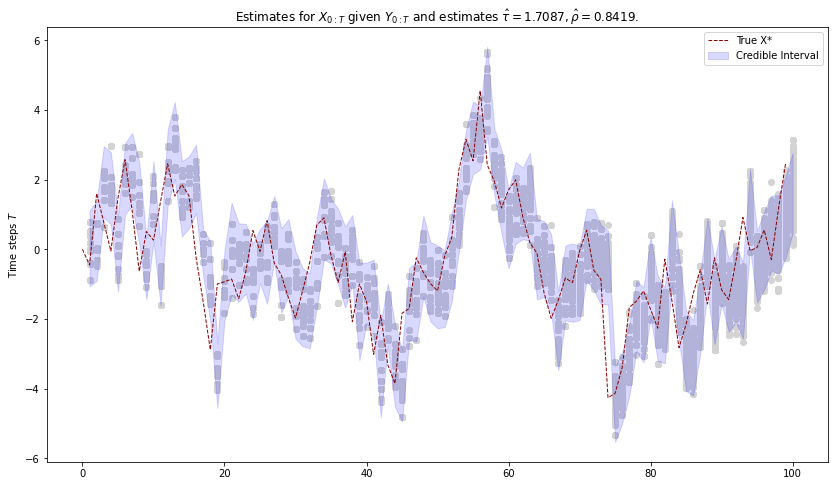

In [ ]:
# X given Y

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

x_axis = np.arange(1, 101, 1)

for num in range(500):
  axs.scatter(x_axis, x_SIR3[num,:], c="lightgrey")

axs.plot(true_x, label = r"True X*", c = "darkred", linestyle ='dashed', linewidth=1)

#axs.plot( CI_arr[:,0], color='orange', label = "Upper CI Bound")
#axs.plot( CI_arr[:,1], color='green', label = "Lower CI Bound")
axs.fill_between(x_axis, (CI_arr[:,0]), (CI_arr[:,1]), color='b', alpha=.15, label="Credible Interval") 

plt.ylabel(r"$X_{0:T}$")
plt.ylabel(r"Time steps $T$")
plt.title(r"Estimates for $X_{0:T}$ given $Y_{0:T}$ and estimates $\hat{\tau}= 1.7087, \hat{\rho} = 0.8419 $.")
plt.legend()
plt.show()

# fig = hist_plot_tau.get_figure()
fig.savefig('qs3_2_X_given_Y.png', dpi=300) 

### KF on a grid

$$ p(\theta | y_{0:n}) \propto p(y_{0:n}| \theta) p(\theta) $$

(0.0, 2.0)

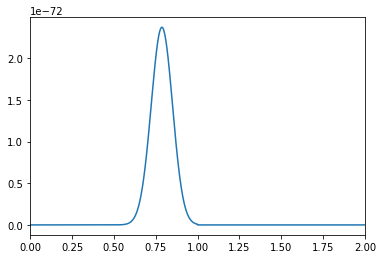

In [ ]:
grid_rho = np.arange(-1, 2, 0.001)
pdf_rho = np.zeros((grid_rho.shape[0], 1))
likelihood_rho = np.zeros((grid_rho.shape[0], 1))

for i, grid_val in enumerate(grid_rho):
  __, __, rec_true = Kalman_Filter(T=100, x0=0, initVar=1, data=y, rho = grid_val )
  pdf_likeli = np.exp(np.sum(np.log(rec_true)))
  likelihood_rho[i] = pdf_likeli
  pdf_rho[i] = pdf_likeli * uniform.pdf(grid_val, loc=-1, scale=2) 

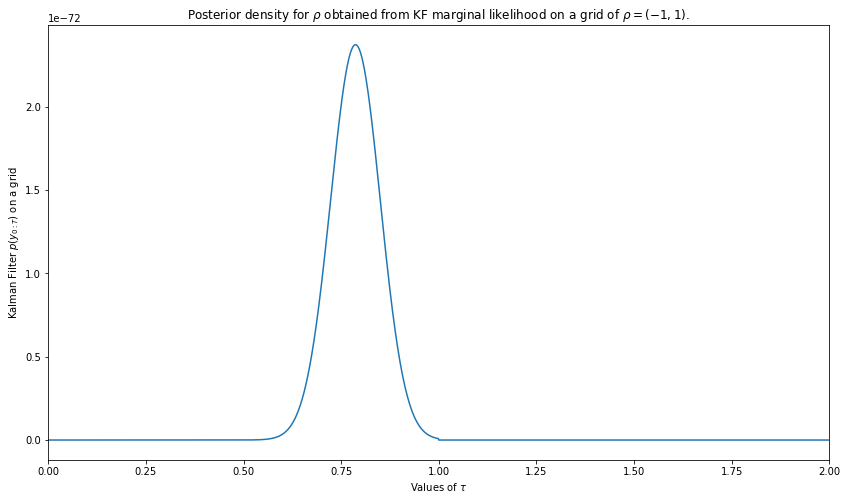

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

axs.plot(grid_rho, pdf_rho )

plt.xlabel(r"Values of $\tau $")
plt.ylabel(r"Kalman Filter $p(y_{0:T})$ on a grid")
plt.title(r"Posterior density for $\rho$ obtained from KF marginal likelihood on a grid of $\rho = (-1,1)$.")
plt.xlim([0,2])
plt.show()
fig.savefig('qs3_2_true_rho_posterior.png', dpi=300) 

In [ ]:
grid_rho[np.argmax(pdf_rho)]

0.7870000000000017

(0.0, 2.0)

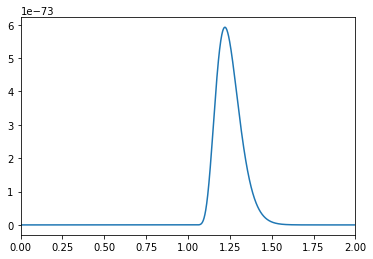

In [ ]:
grid_tau = np.arange(-10, 10, 0.001)
pdf_tau = np.zeros((grid_tau.shape[0], 1))
likelihood_tau = np.zeros((grid_tau.shape[0], 1))

for i, grid_val in enumerate(grid_tau):
  __, __, rec_true = Kalman_Filter(T=100, x0=0, initVar=1, data=y, rho = 0.8, tau = grid_val )
  pdf_likeli = np.exp(np.sum(np.log(rec_true)))
  likelihood_tau[i] = pdf_likeli
  pdf_tau[i] = pdf_likeli * invgamma.pdf(grid_val,1,1)

plt.plot(grid_tau, pdf_tau )
plt.xlim([0,2])

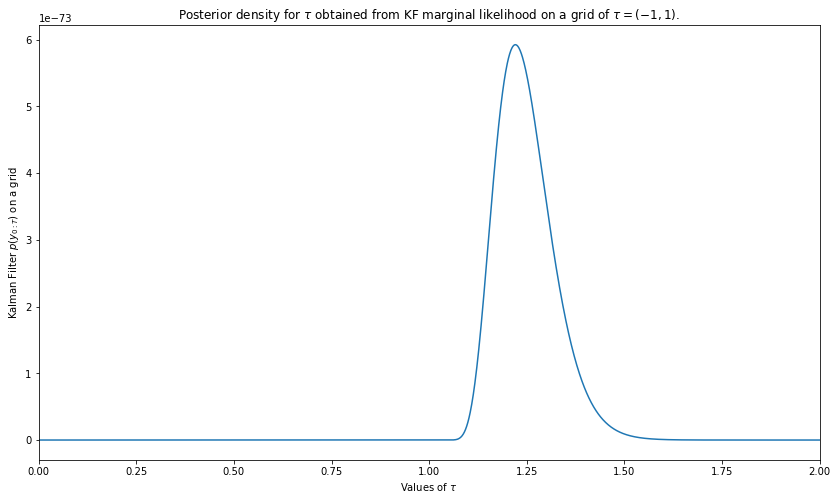

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14,8) )

axs.plot(grid_tau, pdf_tau )

plt.xlabel(r"Values of $\tau $")
plt.ylabel(r"Kalman Filter $p(y_{0:T})$ on a grid")
plt.title(r"Posterior density for $\tau$ obtained from KF marginal likelihood on a grid of $\tau = (-1,1)$.")
plt.xlim([0,2])
plt.show()
fig.savefig('qs3_2_true_tau_posterior.png', dpi=300) 

In [ ]:
grid_tau[np.argmax(pdf_tau)] # grid_tau, pdf_tau 

1.220999999993781

# Part 3.4 The sequential 

In [ ]:
from scipy.stats import norm, invgamma, expon, uniform , multivariate_normal, gamma

In [ ]:
N = 100 #  number of particles
# True parameters and true initial state for generating observations
sigma=0.5
tau=1

T=100


# Declare priors
m0=0
C0=1 # x0 is N(m0,C0)
a0=1 
b0=1 # sigma2 is IG(a0,b0)
c0=1
d0=1 # tau2 is IG(c0,d0)

#  Declare variables for storing particles

xHat=np.zeros((N,T+1))  # particle approximation of p(x_{t-1}|y_{1:t})
#sigma2Hat=np.zeros((N,T+1))
rhoHat=np.zeros((N,T+1))
tau2Hat=np.zeros((N,T+1))

suf1Hat=np.zeros((N,T+1))
suf2Hat=np.zeros((N,T+1))
suf3Hat=np.zeros((N,T+1))
suf4Hat=np.zeros((N,T+1))
w=np.zeros((N,1)) # % normalised weights

# Initialise particles by sampling from priors
xHat[:,0] = m0 + np.sqrt(C0)*np.random.rand(N,)
# sigma2Hat[:,0] = 1/ gamma.rvs(a0,1/b0, size=(N,))
rhoHat[:,0] = uniform.rvs(loc = -1, scale=2, size = (N,))
tau2Hat[:,0] = 1 / gamma.rvs(c0,1/d0, size=(N,))


for t in range(T):

  print(t)
  #  compute weights for resampling
  w= norm.pdf( y[t]*np.ones((N,)), loc = xHat[:,t], scale =np.sqrt((np.ones((N,)) * (sigma**2)) +tau2Hat[:,t]) )
  w = w/np.sum(w)
  print(w.shape)
  
  #  resample with weights prop to  from p(yt|xt-1,simga2,tau2)
  # index= multinomialR([1:N]',w)
  index = np.random.choice( list(range(N)) , N, replace=True, p = w )
  # x[:,t] = x_u[ I[:,t].astype('int32').tolist() ,t]
  xHat[:,t]=xHat[index,t]                  
                                                  
  rhoHat[:,t]=rhoHat[index,t]            
  tau2Hat[:,t]=tau2Hat[index,t]
  
  suf1Hat[:,t]=suf1Hat[index,t]
  suf2Hat[:,t]=suf2Hat[index,t]
  suf3Hat[:,t] = suf3Hat[index,t]
  suf4Hat[:,t] = suf4Hat[index,t]
  
  # propagate state samples
  var_temp = 1/( 1/(np.ones((N,)) * (sigma**2)) + 1./tau2Hat[:,t] )
  mean_temp = var_temp* ( y[t]/(np.ones((N,)) * (sigma**2)) + xHat[:,t]/tau2Hat[:,t] )
  x_temp = mean_temp+np.sqrt(var_temp)* np.random.rand(N,)
                                                  # the particle approx of p(x_t | y_t)

  suf1Hat[:,t+1]=suf1Hat[:,t]+(x_temp-xHat[:,t])**2
  suf2Hat[:,t+1]=suf2Hat[:,t]+(y[t]-x_temp)**2
  #print((suf3Hat[:,t], x_temp).shape)
  suf3Hat[:,t+1] = np.min((suf3Hat[:,t], x_temp))
  suf4Hat[:,t+1] = np.max((suf4Hat[:,t], x_temp))

  xHat[:,t+1]=x_temp # xHat(:,t+1) now contains the particle approx of p(x_t | y_t)
  
  # update model parameter samples   
  # sigma2Hat[:,t+1]= 1/gamma.rvs(a0*np.ones((N,))+t/2, 1/(b0+suf2Hat[:,t+1]/2)  ) # sigma2Hat(:,t+1) now contains the particle approx of p(sigma2_t | y_t)
  rhoHat[:,t+1]= uniform.rvs(loc = suf3Hat[:,t+1], scale=suf4Hat[:,t+1], size = (N,))
  tau2Hat[:,t+1]= 1/ gamma.rvs(c0*np.ones((N,)) + t/2, 1/(d0+suf1Hat[:,t+1]/2)  )

0
(100,)
1
(100,)
2
(100,)
3
(100,)
4
(100,)
5
(100,)
6
(100,)
7
(100,)
8
(100,)
9
(100,)
10
(100,)
11
(100,)
12
(100,)
13
(100,)
14
(100,)
15
(100,)
16
(100,)
17
(100,)
18
(100,)
19
(100,)
20
(100,)
21
(100,)
22
(100,)
23
(100,)
24
(100,)
25
(100,)
26
(100,)
27
(100,)
28
(100,)
29
(100,)
30
(100,)
31
(100,)
32
(100,)
33
(100,)
34
(100,)
35
(100,)
36
(100,)
37
(100,)
38
(100,)
39
(100,)
40
(100,)
41
(100,)
42
(100,)
43
(100,)
44
(100,)
45
(100,)
46
(100,)
47
(100,)
48
(100,)
49
(100,)
50
(100,)
51
(100,)
52
(100,)
53
(100,)
54
(100,)
55
(100,)
56
(100,)
57
(100,)
58
(100,)
59
(100,)
60
(100,)
61
(100,)
62
(100,)
63
(100,)
64
(100,)
65
(100,)
66
(100,)
67
(100,)
68
(100,)
69
(100,)
70
(100,)
71
(100,)
72
(100,)
73
(100,)
74
(100,)
75
(100,)
76
(100,)
77
(100,)
78
(100,)
79
(100,)
80
(100,)
81
(100,)
82
(100,)
83
(100,)
84
(100,)
85
(100,)
86
(100,)
87
(100,)
88
(100,)
89
(100,)
90
(100,)
91
(100,)
92
(100,)
93
(100,)
94
(100,)
95
(100,)
96
(100,)
97
(100,)
98
(100,)
99
(100,)


In [ ]:
rhoHat.shape

(100, 101)

## Plots


In [ ]:
z=1.96
N = 500
CI_arr = np.zeros((101,2))

for t in range(101):
  mean = np.mean(xHat[:,t])
  stdev = np.std(xHat[:,t])
  top = norm.ppf(0.95, loc=mean, scale=np.sqrt(stdev) )  # z * stdev / np.sqrt(N)
  bottom = norm.ppf(0.05, loc=mean, scale=np.sqrt(stdev) )
  #top = mean - confidence_interval
  # bottom = mean + confidence_interval

  CI_arr[t,:] = np.array([top, bottom])
# CI_arr

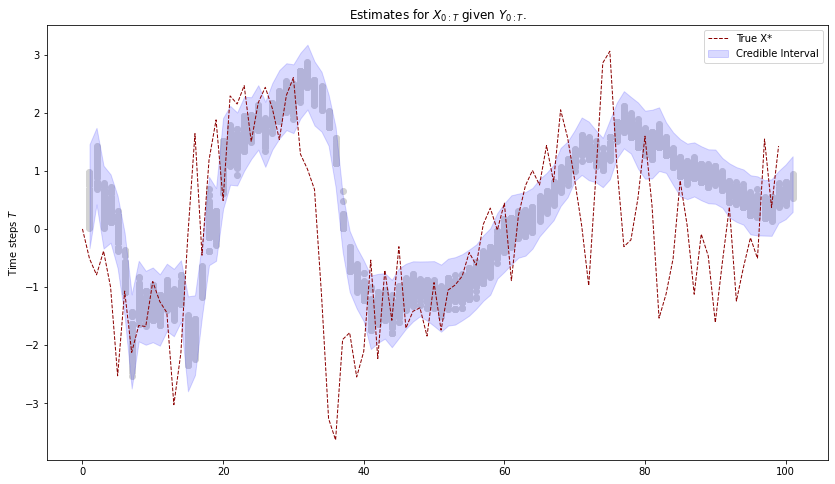

In [ ]:
# X given Y

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

x_axis = np.arange(1, 102, 1)

for num in range(100):
  axs.scatter(x_axis, xHat[num,:], c="lightgrey")

axs.plot(true_x, label = r"True X*", c = "darkred", linestyle ='dashed', linewidth=1)

axs.fill_between(x_axis, (CI_arr[:,0]), (CI_arr[:,1]), color='b', alpha=.15, label="Credible Interval") 

plt.ylabel(r"$X_{0:T}$")
plt.ylabel(r"Time steps $T$")
plt.title(r"Estimates for $X_{0:T}$ given $Y_{0:T}$.")
plt.legend()
plt.show()

# fig = hist_plot_tau.get_figure()
fig.savefig('qs3_4_X_given_Y.png', dpi=300) 

In [ ]:
z=1.96
N = 500
CI_arr_rho = np.zeros((101,2))

for t in range(101):
  mean = np.mean(rhoHat[:,t])
  stdev = np.std(rhoHat[:,t])
  top = norm.ppf(0.95, loc=mean, scale=np.sqrt(stdev) )  # z * stdev / np.sqrt(N)
  bottom = norm.ppf(0.05, loc=mean, scale=np.sqrt(stdev) )
  #top = mean - confidence_interval
  # bottom = mean + confidence_interval

  CI_arr_rho[t,:] = np.array([top, bottom])
# CI_arr

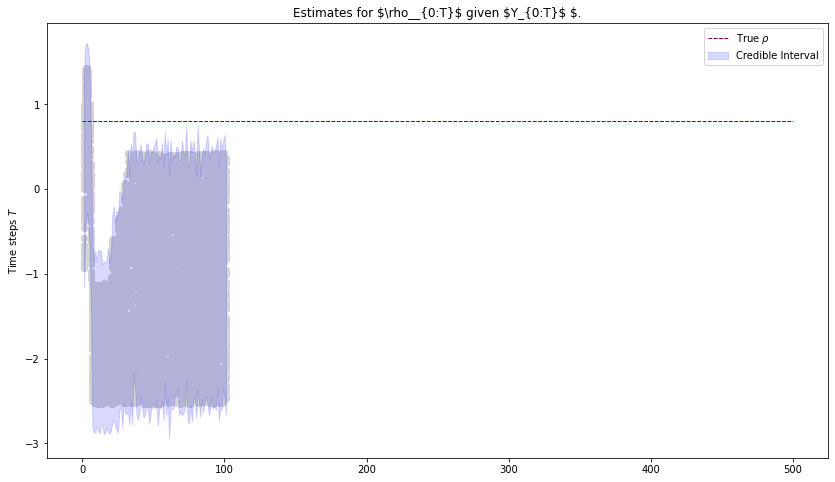

In [ ]:
# X given Y

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

x_axis = np.arange(1, 102,1)

for num in range(100):
  axs.scatter(x_axis, rhoHat[num,:], c="lightgrey")

axs.plot(0.8*np.ones((N+1,)), label = r"True $\rho$", c = "darkred", linestyle ='dashed', linewidth=1)

axs.fill_between(x_axis, (CI_arr_rho[:,0]), (CI_arr_rho[:,1]), color='b', alpha=.15, label="Credible Interval") 

plt.ylabel(r"$\rho_{0:T}$")
plt.ylabel(r"Time steps $T$")
plt.title(r"Estimates for $\rho__{0:T}$ given $Y_{0:T}$ $.")
plt.legend()
plt.show()

# fig = hist_plot_tau.get_figure()
fig.savefig('qs3_4_rho.png', dpi=300) 

In [ ]:
z=1.96
N = 500
CI_arr_tau = np.zeros((101,2))

for t in range(101):
  mean = np.mean(tau2Hat[:,t])
  stdev = np.std(tau2Hat[:,t])
  top = norm.ppf(0.95, loc=mean, scale=np.sqrt(stdev) )  # z * stdev / np.sqrt(N)
  bottom = norm.ppf(0.05, loc=mean, scale=np.sqrt(stdev) )
  #top = mean - confidence_interval
  # bottom = mean + confidence_interval

  CI_arr_tau[t,:] = np.array([top, bottom])
# CI_arr

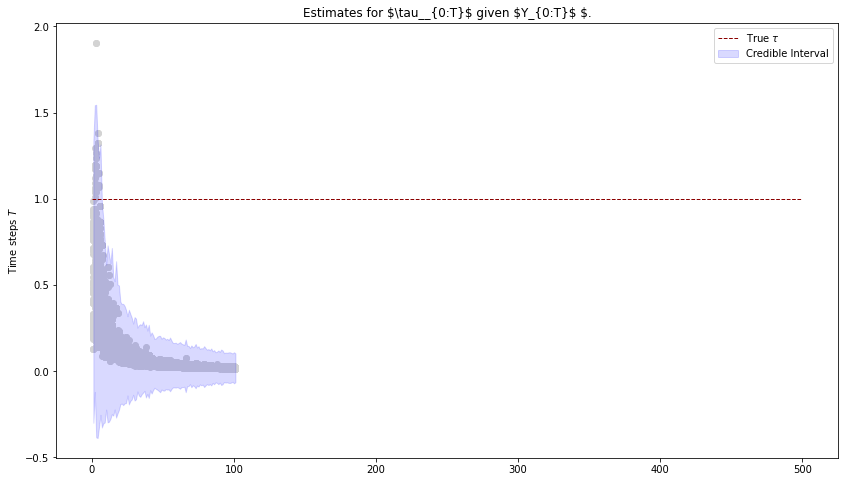

In [ ]:
# X given Y

fig, axs = plt.subplots(1, 1, figsize=(14,8) )

x_axis = np.arange(1, 102,1)

for num in range(100):
  axs.scatter(x_axis, tau2Hat[num,:], c="lightgrey")

axs.plot(1*np.ones((N+1,)), label = r"True $\tau$", c = "darkred", linestyle ='dashed', linewidth=1)

axs.fill_between(x_axis, (CI_arr_tau[:,0]), (CI_arr_tau[:,1]), color='b', alpha=.15, label="Credible Interval") 

plt.ylabel(r"$\rho_{0:T}$")
plt.ylabel(r"Time steps $T$")
plt.title(r"Estimates for $\tau__{0:T}$ given $Y_{0:T}$ $.")
plt.legend()
plt.show()

# fig = hist_plot_tau.get_figure()
fig.savefig('qs3_4_tau.png', dpi=300) 